## PFT

In [1054]:
# Importing necessary libraries
import pandas as pd
import numpy as np


# Libraries for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import time

In [1055]:
# Reading the data file - FIATreeSpeciesCode_pft.csv
df_fia_species = pd.read_csv("./FIA/FIATreeSpeciesCode_pft.csv", sep=";")
df_fia_species_imp = df_fia_species[['SPCD', 'COMMON_NAME', 'PFT']].copy()

# Reading the data file - CA_TREE.csv
df_fia_tree = pd.read_csv("./FIA/CA_TREE.csv", low_memory=False)
df_fia_tree_imp = df_fia_tree[['STATECD', 'PLOT', 'PLT_CN', 'UNITCD', 'COUNTYCD', 'TREE', 'SPCD', 'DIA', 'HT', 'CR']].copy()

# Reading the data file - CA_PLOT.csv
df_fia_plot = pd.read_csv("./FIA/CA_PLOT.csv", low_memory=False)
df_fia_plot_imp = df_fia_plot[['PLOT_STATUS_CD', 'LAT', 'LON', 'ELEV', 'ECOSUBCD', 'CN']].copy()

# Create a dictionary mapping SPCD to COMMON_NAME
fia_ref_species_table = pd.read_csv('./FIA/REF_SPECIES.csv')
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))

# Analyzing the shape
print(df_fia_species_imp.shape)
print(df_fia_tree_imp.shape)
print(df_fia_plot_imp.shape)


(459, 3)
(427519, 10)
(42036, 6)


In [1056]:
list(df_fia_tree.columns)

['CN',
 'PLT_CN',
 'PREV_TRE_CN',
 'INVYR',
 'STATECD',
 'UNITCD',
 'COUNTYCD',
 'PLOT',
 'SUBP',
 'TREE',
 'CONDID',
 'PREVCOND',
 'STATUSCD',
 'SPCD',
 'SPGRPCD',
 'DIA',
 'DIAHTCD',
 'HT',
 'HTCD',
 'ACTUALHT',
 'TREECLCD',
 'CR',
 'CCLCD',
 'TREEGRCD',
 'AGENTCD',
 'CULL',
 'DAMLOC1',
 'DAMTYP1',
 'DAMSEV1',
 'DAMLOC2',
 'DAMTYP2',
 'DAMSEV2',
 'DECAYCD',
 'STOCKING',
 'WDLDSTEM',
 'VOLCFNET',
 'VOLCFGRS',
 'VOLCSNET',
 'VOLCSGRS',
 'VOLBFNET',
 'VOLBFGRS',
 'VOLCFSND',
 'DIACHECK',
 'MORTYR',
 'SALVCD',
 'UNCRCD',
 'CPOSCD',
 'CLIGHTCD',
 'CVIGORCD',
 'CDENCD',
 'CDIEBKCD',
 'TRANSCD',
 'TREEHISTCD',
 'BHAGE',
 'TOTAGE',
 'CULLDEAD',
 'CULLFORM',
 'CULLMSTOP',
 'CULLBF',
 'CULLCF',
 'BFSND',
 'CFSND',
 'SAWHT',
 'BOLEHT',
 'FORMCL',
 'HTCALC',
 'HRDWD_CLUMP_CD',
 'SITREE',
 'CREATED_DATE',
 'MODIFIED_DATE',
 'MORTCD',
 'HTDMP',
 'ROUGHCULL',
 'MIST_CL_CD',
 'CULL_FLD',
 'RECONCILECD',
 'PREVDIA',
 'P2A_GRM_FLG',
 'TREECLCD_NERS',
 'TREECLCD_SRS',
 'TREECLCD_NCRS',
 'TREECLCD_RMRS'

In [1057]:
# Merging the FIA Species and FIA tree based on SPCD
df_fia = df_fia_tree_imp.merge(df_fia_species_imp, on="SPCD", how="left")
# Merging the resulting FIA dataset and FIA plot based on PLOT_CN and CN
df_fia = df_fia.merge(df_fia_plot_imp, left_on="PLT_CN", right_on="CN", how="left")
print(df_fia.shape)
df_fia.head()

(427519, 18)


,STATECD,PLOT,PLT_CN,UNITCD,COUNTYCD,TREE,SPCD,DIA,HT,CR,COMMON_NAME,PFT,PLOT_STATUS_CD,LAT,LON,ELEV,ECOSUBCD,CN
0,6,1,11839,1,15,675267,631.0,3.9,43.0,15.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
1,6,1,11839,1,15,675268,202.0,24.1,95.0,45.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839
2,6,1,11839,1,15,675269,631.0,14.2,56.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
3,6,1,11839,1,15,675270,631.0,10.5,52.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
4,6,1,11839,1,15,675271,202.0,2.5,41.0,25.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839


In [1058]:
df_fia['BasalA'] = (np.pi * df_fia['DIA']**2) / (4 * 144)
df_fia.head()

,STATECD,PLOT,PLT_CN,UNITCD,COUNTYCD,TREE,SPCD,DIA,HT,CR,COMMON_NAME,PFT,PLOT_STATUS_CD,LAT,LON,ELEV,ECOSUBCD,CN,BasalA
0,6,1,11839,1,15,675267,631.0,3.9,43.0,15.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,0.082958
1,6,1,11839,1,15,675268,202.0,24.1,95.0,45.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839,3.167827
2,6,1,11839,1,15,675269,631.0,14.2,56.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,1.099776
3,6,1,11839,1,15,675270,631.0,10.5,52.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,0.601320
4,6,1,11839,1,15,675271,202.0,2.5,41.0,25.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839,0.034088


In [1059]:
# Analyzing the distribution of PFT
df_fia['PFT'].value_counts()

PFT
Evergreen conifer          279767
Evergreen broadleaf         57704
Deciduous broadleaf         49594
Deciduous                   33760
Evergreen                    6431
Flowering plants              230
Unknown                         6
Broadleaf                       4
Nitrogen fixing legumes         2
Deciduous confier               2
Name: count, dtype: int64

In [1060]:
df_fia_ckpt1 = df_fia[['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'SPCD', 'ECOSUBCD', 'PFT']].copy()
df_fia_ckpt1.head()

,DIA,HT,BasalA,LAT,LON,SPCD,ECOSUBCD,PFT
0,3.9,43.0,0.082958,41.478172,-123.946777,631.0,263Ab,Deciduous
1,24.1,95.0,3.167827,41.478172,-123.946777,202.0,263Ab,Evergreen conifer
2,14.2,56.0,1.099776,41.478172,-123.946777,631.0,263Ab,Deciduous
3,10.5,52.0,0.601320,41.478172,-123.946777,631.0,263Ab,Deciduous
4,2.5,41.0,0.034088,41.478172,-123.946777,202.0,263Ab,Evergreen conifer


In [1061]:
df_fia_ckpt1.isna().sum()

DIA         38452
HT          38451
BasalA      38452
LAT             0
LON             0
SPCD            0
ECOSUBCD        0
PFT            19
dtype: int64

In [1062]:
df_fia_ckpt2 = df_fia_ckpt1.dropna(axis=0).copy()
print(df_fia_ckpt2.shape)
df_fia_ckpt2.head()

(389048, 8)


,DIA,HT,BasalA,LAT,LON,SPCD,ECOSUBCD,PFT
0,3.9,43.0,0.082958,41.478172,-123.946777,631.0,263Ab,Deciduous
1,24.1,95.0,3.167827,41.478172,-123.946777,202.0,263Ab,Evergreen conifer
2,14.2,56.0,1.099776,41.478172,-123.946777,631.0,263Ab,Deciduous
3,10.5,52.0,0.601320,41.478172,-123.946777,631.0,263Ab,Deciduous
4,2.5,41.0,0.034088,41.478172,-123.946777,202.0,263Ab,Evergreen conifer


In [1063]:
# Converting from inches to cm
df_fia_ckpt2['DIA_cm'] = df_fia_ckpt2['DIA'] * 2.54
df_fia_ckpt2.head()

,DIA,HT,BasalA,LAT,LON,SPCD,ECOSUBCD,PFT,DIA_cm
0,3.9,43.0,0.082958,41.478172,-123.946777,631.0,263Ab,Deciduous,9.906
1,24.1,95.0,3.167827,41.478172,-123.946777,202.0,263Ab,Evergreen conifer,61.214
2,14.2,56.0,1.099776,41.478172,-123.946777,631.0,263Ab,Deciduous,36.068
3,10.5,52.0,0.601320,41.478172,-123.946777,631.0,263Ab,Deciduous,26.670
4,2.5,41.0,0.034088,41.478172,-123.946777,202.0,263Ab,Evergreen conifer,6.350


In [1064]:
df_fia_ckpt2.isna().sum()

DIA         0
HT          0
BasalA      0
LAT         0
LON         0
SPCD        0
ECOSUBCD    0
PFT         0
DIA_cm      0
dtype: int64

In [1065]:
# Define the ECOSUBCDs to keep
ecosubcd_keep = ['M261Ep', '261Ba', 'M261Em', '263Am', 'M261Ej']

# Filter the DataFrame
df_fia_ckpt2_filtered = df_fia_ckpt2[df_fia_ckpt2['ECOSUBCD'].isin(ecosubcd_keep)]
# Shuffle the filtered DataFrame
df_fia_ckpt2_filtered_shuffled = df_fia_ckpt2_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

df_fia_ecosubcd = df_fia_ckpt2_filtered_shuffled['ECOSUBCD']

# One hot encoding the categorical variable ECOSUBCD
df_encoded = pd.get_dummies(df_fia_ckpt2_filtered_shuffled, columns=['ECOSUBCD'])
#df_encoded = df_encoded.drop(['ECOSUBCD_M261Ep'], axis=1)
df_encoded['ECOSUBCD'] = df_fia_ecosubcd
df_encoded.head()

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep


In [1066]:
# # List of target columns
# columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Sum of True values per column
# true_counts = df_encoded[columns].sum()

# # Total True values across all specified columns
# total_true = true_counts.sum()

# # Calculate distribution as percentage
# true_distribution = (true_counts / total_true * 100).round(2)

# print(true_distribution)

In [1067]:
df_encoded.shape

(23726, 14)

In [1068]:
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_encoded['PFT'] = df_encoded['PFT'].replace(replace_dict)
df_encoded = df_encoded[df_encoded['PFT'] != 'Broadleaf']
df_encoded['PFT'].value_counts()

PFT
Evergreen conifer      16936
Evergreen broadleaf     3476
Deciduous broadleaf     2872
Evergreen                425
Flowering plants          15
Name: count, dtype: int64

In [1069]:
# # List of target columns
# occ_columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Group by PFT and sum the True values in each OCC column
# pft_occ_true_counts = df_encoded.groupby('PFT')[occ_columns].sum()

# # Get total True counts per PFT (summing across all OCC columns)
# pft_total_true = pft_occ_true_counts.sum(axis=1)

# # Calculate distribution: OCC region as % of total True per PFT
# pft_occ_distribution = (pft_occ_true_counts.T / pft_total_true).T * 100
# pft_occ_distribution = pft_occ_distribution.round(2)

# pft_occ_distribution

In [1070]:
df_encoded.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    98.969072
          Deciduous broadleaf     1.030928
263Am     Evergreen broadleaf    34.610778
          Evergreen conifer      24.431138
          Deciduous broadleaf    20.958084
          Evergreen              20.000000
M261Ej    Evergreen conifer      96.108742
          Deciduous broadleaf     3.837953
          Flowering plants        0.053305
M261Em    Evergreen conifer      82.695741
          Evergreen broadleaf     8.926294
          Deciduous broadleaf     8.365213
          Flowering plants        0.012752
M261Ep    Evergreen conifer      62.702124
          Evergreen broadleaf    19.540230
          Deciduous broadleaf    16.754335
          Evergreen               0.886421
          Flowering plants        0.116891
Name: proportion, dtype: float64

In [1071]:
df_clean = df_encoded.copy()
independent_variables = ['DIA_cm', 'HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']
dependent_variable = "PFT"
include_variables = independent_variables + [dependent_variable]

# Separate features (X) and target (y)
X = df_clean[independent_variables]
y = df_clean[dependent_variable]

# Check class distribution
print("Class distribution in the dataset:")
print(y.value_counts(normalize=True))

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Encoded classes: {list(le.classes_)}")
print(f"Number of classes: {num_classes}")

# Split into training and test sets (stratify to maintain class proportions)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print(f"Original Training set size: {len(X_train)}")
print(f"Original Test set size: {len(X_test)}")

# Feature Scaling
numerical_cols = ['DIA_cm','HT', 'BasalA', 'LAT', 'LON'] # Adjust if you have others
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

scaler = StandardScaler()

# Scale numerical features
# Fit on training data only, then transform train and test data
X_train_scaled_num = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_num = scaler.transform(X_test[numerical_cols])

X_train_processed = np.hstack((X_train_scaled_num, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled_num, X_test[categorical_cols].values))

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.30, random_state=42, stratify=y_train_encoded
)
start_time = time.time()

# {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
# final_model = XGBClassifier(
#     subsample=0.9,
#     n_estimators=300,
#     min_child_weight=1,
#     max_depth=15,
#     learning_rate=0.2,
#     gamma=0.1,
#     colsample_bytree=0.8,
#     objective='multi:softmax',
#     num_class=num_classes,       # Explicitly set number of classes
#     eval_metric='mlogloss',
#     random_state=42
# )

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# label_encoder_pft = LabelEncoder()
# y_train_encoded = label_encoder_pft.fit_transform(y_train)
# y_test_encoded = label_encoder_pft.transform(y_test)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Best Base Models ---

rf = RandomForestClassifier(
    n_estimators=317,
    max_depth=23,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    criterion='log_loss',
    class_weight='balanced',
    random_state=42
)

et = ExtraTreesClassifier(
    n_estimators=317,
    max_depth=23,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    criterion='log_loss',
    random_state=42
)

dt = DecisionTreeClassifier(
    max_depth=14,
    min_samples_split=13,
    min_samples_leaf=3,
    max_features=None,
    criterion='gini',
    splitter='best',
    random_state=42
)

bagging = BaggingClassifier(
    n_estimators=71,
    max_samples=0.616,
    max_features=0.987,
    bootstrap=False,
    bootstrap_features=False,
    random_state=42
)

# --- Meta-Learner ---
meta_learner = XGBClassifier(
    n_estimators=180,
    max_depth=13,
    learning_rate=0.0116,
    subsample=0.803,
    colsample_bytree=0.886,
    gamma=0.994,
    reg_alpha=0.711,
    reg_lambda=0.790,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# --- Stacking Ensemble ---
final_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('dt', dt),
        ('bagging', bagging)
    ],
    final_estimator=meta_learner,
    cv=skf,
    n_jobs=-1,
    passthrough=True
)


# final_model = BernoulliNB()

# Use early stopping
eval_set = [(X_val, y_val)]
final_model.fit(
    X_train_final,
    y_train_final, # Stop if metric doesn't improve for 50 rounds
    # eval_set=eval_set,
    # verbose=False # Set to True to see training progress
)

print(f"Final model training finished. Time: {time.time() - start_time:.2f} seconds")
# print(f"Optimal number of trees found by early stopping: {final_model.best_ntree_limit}") # If early stopping was triggered
print("-" * 30)

# --- 5. Predict and Evaluate on the Test Set ---
print("Evaluating model on the test set...")

# Predict using the final model (either best_xgb_model or final_model if retrained)
predicted_pft_test_encoded = final_model.predict(X_test_processed)

# Decode predictions for readability
predicted_labels_decoded = le.inverse_transform(predicted_pft_test_encoded)

# Get original test labels for comparison
original_test_labels = le.inverse_transform(y_test_encoded)

# Classification report using original labels
report = classification_report(
    original_test_labels,
    predicted_labels_decoded,
    zero_division=0,
    target_names=le.classes_
)
print("Classification Report on Test Set:")
print(report)

# Overall accuracy
accuracy = accuracy_score(original_test_labels, predicted_labels_decoded)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("-" * 30)

# --- 6. Feature Importance ---
print("Plotting Feature Importance...")
try:
    # Create importance plot using feature names
    # Need to reconstruct feature names after hstack
    feature_names = numerical_cols + categorical_cols # Order matches hstack
    importance_scores = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_scores})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel("XGBoost Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance Plot")
    plt.gca().invert_yaxis() # Display most important features at the top
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

Class distribution in the dataset:
PFT
Evergreen conifer      0.713876
Evergreen broadleaf    0.146518
Deciduous broadleaf    0.121059
Evergreen              0.017914
Flowering plants       0.000632
Name: proportion, dtype: float64
Encoded classes: ['Deciduous broadleaf', 'Evergreen', 'Evergreen broadleaf', 'Evergreen conifer', 'Flowering plants']
Number of classes: 5
Original Training set size: 17793
Original Test set size: 5931


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final model training finished. Time: 16.58 seconds
------------------------------
Evaluating model on the test set...
Classification Report on Test Set:
                     precision    recall  f1-score   support

Deciduous broadleaf       0.75      0.64      0.69       718
          Evergreen       0.68      0.75      0.71       106
Evergreen broadleaf       0.85      0.81      0.83       869
  Evergreen conifer       0.93      0.96      0.95      4234
   Flowering plants       1.00      0.50      0.67         4

           accuracy                           0.90      5931
          macro avg       0.84      0.73      0.77      5931
       weighted avg       0.89      0.90      0.89      5931

Final Test Accuracy: 0.8972
------------------------------
Plotting Feature Importance...
Could not plot feature importance: 'StackingClassifier' object has no attribute 'feature_importances_'


### Working with TLS data

In [1082]:
tls_treelist_df = pd.read_csv("./TLS/TLS_treelist.csv", index_col=0)
df_plot_identification = pd.read_csv("./TLS/blk_plot_identification.csv")
df_tls_data = tls_treelist_df.merge(df_plot_identification,on="plot_blk", how="left")
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,plot_num,inventory_date,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0


In [1083]:
df_tls_data['site_name_label'].value_counts()

site_name_label
Calaveras Big Trees State Park    408
Independence Lake (IND)           229
Shaver Lake (SHA)                 209
Winton-Schaads VMP (WIN)          176
Pacific Union College (PUC)       176
Sedgwick Reserve (SDR)             88
Name: count, dtype: int64

In [1084]:
df_tls_data = df_tls_data.dropna(axis=0).copy()

In [767]:
pip install shapley

Defaulting to user installation because normal site-packages is not writeable
  Using cached shapley-1.0.3-py3-none-any.whl
  Using cached numpy-1.20.3.zip (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Using cached numba-0.59.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached numba-0.59.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached numba-0.58.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.41.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached numba-0.58.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached numba-0.57.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Usin

In [1085]:
from shapely.geometry import Point
import geopandas as gpd

gdfs = []
for crs in df_tls_data["plot_coord_srs"].unique():
    print(crs)
    df_crs = df_tls_data[df_tls_data["plot_coord_srs"] == crs]
    geometry = [Point(xy) for xy in zip(df_crs["plot_coord_x"], df_crs["plot_coord_y"])]
    gdf = gpd.GeoDataFrame(df_crs, geometry=geometry, crs=f"EPSG:{crs}")
    gdf = gdf.to_crs(epsg=4326)
    gdfs.append(gdf)

# Recombine the GeoDataFrames
gdf = pd.concat(gdfs)
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y
with pd.option_context("display.width", 140):
    print(gdf[["site_name_label", "latitude", "longitude"]])

26911.0
26910.0
                     site_name_label   latitude   longitude
0                  Shaver Lake (SHA)  37.100323 -119.272897
1                  Shaver Lake (SHA)  37.100323 -119.272897
2                  Shaver Lake (SHA)  37.100323 -119.272897
3                  Shaver Lake (SHA)  37.100323 -119.272897
4                  Shaver Lake (SHA)  37.100323 -119.272897
...                              ...        ...         ...
1377  Calaveras Big Trees State Park  38.254746 -120.223306
1378  Calaveras Big Trees State Park  38.254746 -120.223306
1379  Calaveras Big Trees State Park  38.254746 -120.223306
1380  Calaveras Big Trees State Park  38.254746 -120.223306
1381  Calaveras Big Trees State Park  38.254746 -120.223306

[1286 rows x 3 columns]


In [1086]:
df_tls_data.columns

Index(['TreeID', 'X', 'Y', 'Radius', 'Error', 'H', 'h_radius', 'DBH', 'BasalA',
       'plot_blk', 'Unnamed: 0', 'inventory_id', 'site_project',
       'site_project_label', 'site_name', 'site_name_label',
       'inventory_pre_post_fire', 'inventory_pre_post_fire_label', 'plot_num',
       'inventory_date', 'inventory_hour', 'plot_coord_x', 'plot_coord_y',
       'plot_coord_srs', 'plot_declination', 'inventory_plot_diam',
       'plot_slopeper', 'plot_aspectdegre'],
      dtype='object')

In [1087]:
df_tls_data['LAT'] = gdf['latitude']
df_tls_data['LON'] = gdf['longitude']
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre,LAT,LON
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897


In [770]:
# plt.figure(figsize=(8, 5))
# plt.hist(df_tls_data['LAT'], bins=20, edgecolor='black')
# plt.hist(df_encoded['LAT'], bins=20, edgecolor='red', alpha=0.5)
# plt.xlabel('LAT')
# plt.ylabel('Frequency')
# plt.title('Histogram of LAT')
# plt.tight_layout()
# plt.show()

In [771]:
# plt.figure(figsize=(8, 5))
# plt.hist(df_tls_data['LON'], bins=20, edgecolor='black')
# plt.hist(df_encoded['LON'], bins=20, edgecolor='red', alpha=0.5)
# plt.xlabel('LON')
# plt.ylabel('Frequency')
# plt.title('Histogram of LON')
# plt.tight_layout()
# plt.show()

In [1088]:
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre,LAT,LON
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,37.100323,-119.272897


In [1089]:
df_tls_data.columns

Index(['TreeID', 'X', 'Y', 'Radius', 'Error', 'H', 'h_radius', 'DBH', 'BasalA',
       'plot_blk', 'Unnamed: 0', 'inventory_id', 'site_project',
       'site_project_label', 'site_name', 'site_name_label',
       'inventory_pre_post_fire', 'inventory_pre_post_fire_label', 'plot_num',
       'inventory_date', 'inventory_hour', 'plot_coord_x', 'plot_coord_y',
       'plot_coord_srs', 'plot_declination', 'inventory_plot_diam',
       'plot_slopeper', 'plot_aspectdegre', 'LAT', 'LON'],
      dtype='object')

In [1092]:
df_tls_data.to_csv("pft_tls.csv", index=False)

In [1090]:
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_tls_data['ECOSUBCD'] = df_tls_data['site_name_label'].map(site_to_ecosubcd)

print(df_tls_data[['site_name_label', 'ECOSUBCD', 'LAT', 'LON']].head())

     site_name_label ECOSUBCD        LAT         LON
0  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
1  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
2  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
3  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
4  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897


In [1091]:
df_tls_data['ECOSUBCD'].value_counts()

ECOSUBCD
M261Em    584
M261Ej    229
M261Ep    209
263Am     176
261Ba      88
Name: count, dtype: int64

In [1022]:
df_tls_data = df_tls_data.dropna(axis=0).copy()

In [1023]:
# def get_region_flags(lat, lon):
#     return pd.Series({
#         'OCC.NC_X': int(38 <= lat <= 42 and -124 <= lon <= -120),
#         'OCC.NE_X': int(42 < lat <= 49 and -120 < lon <= -104),  # Assuming NE means inland north
#         'OCC.PNW_X': int(42 < lat <= 49 and -125 <= lon <= -116),
#         'OCC.RM_X': int(37 <= lat <= 49 and -116 < lon <= -104),
#         'OCC.SO_X': int(32 <= lat < 38 and -124 <= lon <= -114),
#     })

# # Apply to your dataframe
# df_tls_data[['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']] = df_tls_data.apply(
#     lambda row: get_region_flags(row['LAT'], row['LON']),
#     axis=1
# )

# print(df_tls_data[['LAT', 'LON', 'OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']].head())

In [1024]:
TLS_X = df_tls_data[['DBH', 'H', 'BasalA', 'LAT', 'LON', 'ECOSUBCD']].copy()

In [1025]:
# match the feautre names 
TLS_X.columns = ['DIA_cm', 'HT', 'BasalA', 'LAT', 'LON', 'ECOSUBCD']

In [1026]:
# One hot encoding the categorical variable ECOSUBCD
TLS_X_ECOSUBCD = TLS_X['ECOSUBCD'].copy()
TLS_X = pd.get_dummies(TLS_X, columns=['ECOSUBCD'])
#TLS_X = TLS_X.drop(['ECOSUBCD_M261Ep'], axis=1)
TLS_X = TLS_X[['DIA_cm', 'HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']]
TLS_X['ECOSUBCD'] = TLS_X_ECOSUBCD
# Shuffle the filtered DataFrame
TLS_X_shuffled = TLS_X.sample(frac=1, random_state=42).reset_index(drop=True)
TLS_X_shuffled = TLS_X.copy()
TLS_X_shuffled['LAT'] = TLS_X_shuffled['LAT'].fillna(TLS_X_shuffled['LAT'].mode())
TLS_X_shuffled['LON'] = TLS_X_shuffled['LON'].fillna(TLS_X_shuffled['LON'].mode())
TLS_X_shuffled.head()

,DIA_cm,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,20.987379,12.560,2.402324,37.100323,-119.272897,False,False,False,False,M261Ep
1,13.105771,8.742,0.936786,37.100323,-119.272897,False,False,False,False,M261Ep
2,59.840890,13.469,19.530404,37.100323,-119.272897,False,False,False,False,M261Ep
3,21.040854,18.144,2.414582,37.100323,-119.272897,False,False,False,False,M261Ep
4,16.390056,13.790,1.465130,37.100323,-119.272897,False,False,False,False,M261Ep


In [1028]:
TLS_X_shuffled.shape

(1286, 10)

In [1029]:
# Feature Scaling

independent_variables = ['DIA_cm','HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']

# "DIA_cm", 'HT', 'LAT', 'LON', "OCC.NC_X", "OCC.NE_X", "OCC.PNW_X", "OCC.RM_X",
#                          'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
#                          'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em'

numerical_cols = ['DIA_cm', 'HT', 'BasalA', 'LAT', 'LON'] # Adjust if you have others
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

In [1030]:
# Scale numerical features
# Fit on training data only, then transform train and test data
TLS_X_scaled = scaler.fit_transform(TLS_X_shuffled[numerical_cols])
print(len(TLS_X_scaled))
TLS_train_processed = np.hstack((TLS_X_scaled, TLS_X_shuffled[categorical_cols].values))
print(len(TLS_train_processed))
predicted_pft_tls = final_model.predict(TLS_train_processed)
print(len(predicted_pft_tls))
# X_test_scaled_num = scaler.transform(X_test[numerical_cols])

1286
1286
1286


In [1031]:
# Decode predictions for readability
predicted_labels_TLS_decoded = le.inverse_transform(predicted_pft_tls)
len(predicted_labels_TLS_decoded)

1286

In [1032]:
TLS_X['predicted_PFT'] = predicted_labels_TLS_decoded
TLS_X['predicted_PFT'].value_counts()

predicted_PFT
Evergreen conifer      910
Evergreen broadleaf    362
Deciduous broadleaf     12
Evergreen                2
Name: count, dtype: int64

In [1033]:
# # List of target columns
# occ_columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Group by PFT and sum the True values in each OCC column
# pft_occ_true_counts = TLS_X.groupby('predicted_PFT')[occ_columns].sum()

# # Get total True counts per PFT (summing across all OCC columns)
# pft_total_true = pft_occ_true_counts.sum(axis=1)

# # Calculate distribution: OCC region as % of total True per PFT
# pft_occ_distribution = (pft_occ_true_counts.T / pft_total_true).T * 100
# pft_occ_distribution = pft_occ_distribution.round(2)

# pft_occ_distribution

In [1034]:
# Calculate value counts as percentages
percentages = TLS_X['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

predicted_PFT
Evergreen conifer      70.76
Evergreen broadleaf    28.15
Deciduous broadleaf     0.93
Evergreen               0.16
Name: proportion, dtype: float64


In [1035]:
# Calculate value counts as percentages
percentages = TLS_X.groupby('ECOSUBCD')['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf    100.00
263Am     Evergreen broadleaf     64.20
          Evergreen conifer       34.66
          Evergreen                1.14
M261Ej    Evergreen conifer      100.00
M261Em    Evergreen conifer       86.82
          Evergreen broadleaf     13.18
M261Ep    Evergreen conifer       54.07
          Evergreen broadleaf     40.19
          Deciduous broadleaf      5.74
Name: proportion, dtype: float64


In [1036]:
"""
ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    98.969072
          Deciduous broadleaf     1.030928
263Am     Evergreen broadleaf    34.610778
          Evergreen conifer      24.431138
          Deciduous broadleaf    20.958084
          Evergreen              20.000000
M261Ej    Evergreen conifer      96.108742
          Deciduous broadleaf     3.837953
          Flowering plants        0.053305
M261Em    Evergreen conifer      82.695741
          Evergreen broadleaf     8.926294
          Deciduous broadleaf     8.365213
          Flowering plants        0.012752
M261Ep    Evergreen conifer      62.702124
          Evergreen broadleaf    19.540230
          Deciduous broadleaf    16.754335
          Evergreen               0.886421
          Flowering plants        0.116891
"""

'\nECOSUBCD  PFT                \n261Ba     Evergreen broadleaf    98.969072\n          Deciduous broadleaf     1.030928\n263Am     Evergreen broadleaf    34.610778\n          Evergreen conifer      24.431138\n          Deciduous broadleaf    20.958084\n          Evergreen              20.000000\nM261Ej    Evergreen conifer      96.108742\n          Deciduous broadleaf     3.837953\n          Flowering plants        0.053305\nM261Em    Evergreen conifer      82.695741\n          Evergreen broadleaf     8.926294\n          Deciduous broadleaf     8.365213\n          Flowering plants        0.012752\nM261Ep    Evergreen conifer      62.702124\n          Evergreen broadleaf    19.540230\n          Deciduous broadleaf    16.754335\n          Evergreen               0.886421\n          Flowering plants        0.116891\n'

### FIELD Data - GROUND Truth

In [1037]:
df_field = pd.read_csv("./Field/03_tree.csv")
df_field_plot = pd.read_csv("./Field/01_plot_identification.csv")

print(df_field.shape)
print(df_field_plot.shape)

(2147, 22)
(163, 61)


In [1038]:
field_names = set(df_field['tree_sp_scientific_name'].value_counts().index)
fia_names = set(df_fia_species['SCI_NAME'].value_counts().index)
difference = list(field_names - fia_names)
difference

[]

In [1039]:
replace_dict = {'Salix spp.': 'Salix sp.', 'Quercus spp.': 'Quercus sp.', 'Cornus nuttallii': 'Cornus nuttalii'} 
df_fia_species['SCI_NAME'] = df_fia_species['SCI_NAME'].replace(replace_dict)

In [1040]:
df_field = df_field.merge(df_field_plot, on="inventory_id", how="left")
df_field.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail


In [1041]:
df_field.shape

(2147, 82)

In [1042]:
df_field = df_field.merge(df_fia_species, left_on="tree_sp_scientific_name", right_on="SCI_NAME", how="left")
df_field.shape

(2147, 94)

In [1043]:
# Replacing Deciduous with Deciduous broadleaf as both are the same
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_field['PFT'] = df_field['PFT'].replace(replace_dict)

In [1044]:
df_field[df_field['tree_sp_scientific_name'] == 'Notholicarpos densiflorus']['PFT'] = 'Evergreen broadleaf'

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_77874/1731695054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_field[df_field['tree_sp_scientific_name'] == 'Notholicarpos densiflorus']['PFT'] = 'Evergreen broadleaf'


In [1045]:
# Calculate value counts as percentages
percentages = df_field['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

PFT
Evergreen conifer      69.82
Evergreen broadleaf    21.43
Deciduous broadleaf     8.71
Tree                    0.05
Name: proportion, dtype: float64


In [1046]:
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_field['ECOSUBCD'] = df_field['site_name_label'].map(site_to_ecosubcd)
df_field['ECOSUBCD'].value_counts()

# print(df_field[['site_name_label', 'ECOSUBCD', 'LAT', 'LON']].head())

ECOSUBCD
M261Em    814
261Ba     364
M261Ej    358
M261Ep    348
263Am     263
Name: count, dtype: int64

In [1047]:
# Calculate value counts as percentages
percentages = df_field.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    84.07
          Deciduous broadleaf    15.93
263Am     Evergreen broadleaf    50.95
          Evergreen conifer      40.68
          Deciduous broadleaf     8.37
M261Ej    Evergreen conifer      93.58
          Deciduous broadleaf     6.42
M261Em    Evergreen conifer      89.31
          Deciduous broadleaf     8.11
          Evergreen broadleaf     2.46
          Tree                    0.12
M261Ep    Evergreen conifer      94.83
          Deciduous broadleaf     5.17
Name: proportion, dtype: float64


In [1048]:
# Calculate value counts as percentages
percentages = TLS_X.groupby('ECOSUBCD')['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf    100.00
263Am     Evergreen broadleaf     64.20
          Evergreen conifer       34.66
          Evergreen                1.14
M261Ej    Evergreen conifer      100.00
M261Em    Evergreen conifer       86.82
          Evergreen broadleaf     13.18
M261Ep    Evergreen conifer       54.07
          Evergreen broadleaf     40.19
          Deciduous broadleaf      5.74
Name: proportion, dtype: float64


In [802]:
"""
ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf     84.09
          Deciduous broadleaf     15.91
263Am     Evergreen conifer       42.61
          Deciduous broadleaf     28.98
          Evergreen broadleaf     28.41
M261Ej    Evergreen conifer      100.00
M261Em    Evergreen conifer       88.53
          Evergreen broadleaf     11.47
M261Ep    Evergreen broadleaf     95.22
          Deciduous broadleaf      3.83
          Evergreen conifer        0.96
"""

'\nECOSUBCD  predicted_PFT      \n261Ba     Evergreen broadleaf     84.09\n          Deciduous broadleaf     15.91\n263Am     Evergreen conifer       42.61\n          Deciduous broadleaf     28.98\n          Evergreen broadleaf     28.41\nM261Ej    Evergreen conifer      100.00\nM261Em    Evergreen conifer       88.53\n          Evergreen broadleaf     11.47\nM261Ep    Evergreen broadleaf     95.22\n          Deciduous broadleaf      3.83\n          Evergreen conifer        0.96\n'

In [803]:
TLS_X

,DIA_cm,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,predicted_PFT
0,20.987379,12.560,2.402324,0.000019,-121.488648,False,False,False,False,M261Ep,Evergreen broadleaf
1,13.105771,8.742,0.936786,0.000010,-121.488722,False,False,False,False,M261Ep,Evergreen broadleaf
2,59.840890,13.469,19.530404,0.000009,-121.488725,False,False,False,False,M261Ep,Evergreen broadleaf
3,21.040854,18.144,2.414582,0.000079,-121.488726,False,False,False,False,M261Ep,Evergreen conifer
4,16.390056,13.790,1.465130,0.000002,-121.488731,False,False,False,False,M261Ep,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,1.636854,0.000025,-127.488832,False,False,False,True,M261Em,Evergreen conifer
1378,24.252048,23.077,3.207835,-0.000084,-127.488726,False,False,False,True,M261Em,Evergreen conifer
1379,17.835430,30.127,1.734931,0.000062,-127.488817,False,False,False,True,M261Em,Evergreen conifer
1380,14.208700,29.300,1.101093,-0.000074,-127.488768,False,False,False,True,M261Em,Evergreen conifer


## GENUS

In [804]:
df_encoded_copy = df_encoded.copy()

In [805]:
df_encoded = df_encoded_copy.copy()

In [806]:
df_encoded

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23721,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,False,M261Em
23722,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,True,M261Ep
23723,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,True,M261Ep
23724,6.0,20.0,0.196350,35.565308,-118.647105,333.0,Deciduous broadleaf,15.240,False,False,False,False,True,M261Ep


In [807]:
df_ref_species = pd.read_csv('./FIA/REF_SPECIES.csv')
df_ref_species = df_ref_species[['SPCD', 'GENUS', 'SPECIES', 'COMMON_NAME']].copy()
print(f"Shape: {df_ref_species.shape}")
df_ref_species.head()

Shape: (2677, 4)


,SPCD,GENUS,SPECIES,COMMON_NAME
0,6156.0,Araucaria,excelsa,Norfolk Island pine
1,6157.0,Araucaria,heterophylla,Norfolk Island pine
2,6158.0,Araucaria,spp.,Araucaria
3,6159.0,Archontophoenix,alexandrae,Alexandra palm
4,6160.0,Archontophoenix,cunninghamiana,Bangalow palm


In [808]:
df_encoded

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23721,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,False,M261Em
23722,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,True,M261Ep
23723,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,True,M261Ep
23724,6.0,20.0,0.196350,35.565308,-118.647105,333.0,Deciduous broadleaf,15.240,False,False,False,False,True,M261Ep


In [809]:
df_encoded = df_encoded.merge(df_ref_species, on="SPCD", how="left")
print(f"Shape: {df_encoded.shape}")
df_encoded.head()

Shape: (23724, 17)


,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine


In [810]:
df_encoded['GENUS'].value_counts()

GENUS
Pinus             5981
Quercus           5489
Calocedrus        5072
Abies             5058
Pseudotsuga        654
Umbellularia       425
Arbutus            229
Aesculus           169
Cornus             125
Cercocarpus        118
Acer                76
Juniperus           68
Sequoia             57
Lithocarpus         57
Alnus               43
Sequoiadendron      34
Populus             30
Prunus              15
Torreya              6
Cupressus            6
Fraxinus             5
Platanus             4
Eucalyptus           3
Name: count, dtype: int64

In [811]:
len(df_encoded['GENUS'].unique())

23

In [812]:
# List of genera to keep
genera_to_keep = ['Abies', 'Calocedrus', 'Pinus', 'Cornus', 'Populus',
                  'Quercus', 'Sequoiadendron', 'Acer', 'Pseudotsuga', 'Arbutus','Salix'
                  'Notholicarpos']

# Filter the DataFrame
df_encoded = df_encoded[df_encoded["GENUS"].isin(genera_to_keep)].copy()
df_encoded.head()

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine


In [813]:
df_encoded['GENUS'].value_counts()

GENUS
Pinus             5981
Quercus           5489
Calocedrus        5072
Abies             5058
Pseudotsuga        654
Arbutus            229
Cornus             125
Acer                76
Sequoiadendron      34
Populus             30
Name: count, dtype: int64

In [814]:
# If Genus less than 5000 then merge those into "Other"
#df_encoded['GENUS'] = df_encoded['GENUS'].where(df_encoded['GENUS'].map(df_encoded['GENUS'].value_counts()) > 5000, 'Other')
#df_encoded['GENUS'].value_counts()

In [815]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22748 entries, 0 to 23723
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DIA              22748 non-null  float64
 1   HT               22748 non-null  float64
 2   BasalA           22748 non-null  float64
 3   LAT              22748 non-null  float64
 4   LON              22748 non-null  float64
 5   SPCD             22748 non-null  float64
 6   PFT              22748 non-null  object 
 7   DIA_cm           22748 non-null  float64
 8   ECOSUBCD_261Ba   22748 non-null  bool   
 9   ECOSUBCD_263Am   22748 non-null  bool   
 10  ECOSUBCD_M261Ej  22748 non-null  bool   
 11  ECOSUBCD_M261Em  22748 non-null  bool   
 12  ECOSUBCD_M261Ep  22748 non-null  bool   
 13  ECOSUBCD         22748 non-null  object 
 14  GENUS            22748 non-null  object 
 15  SPECIES          22748 non-null  object 
 16  COMMON_NAME      22748 non-null  object 
dtypes: bool(5), float

In [816]:
"""# Drop all outlier rows using BasalA using IQR
Q1 = df_encoded['BasalA'].quantile(0.25)
Q3 = df_encoded['BasalA'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_encoded = df_encoded[(df_encoded['BasalA'] >= lower_bound) & (df_encoded['BasalA'] <= upper_bound)]
print(f"Shape: {df_encoded.shape}")"""

'# Drop all outlier rows using BasalA using IQR\nQ1 = df_encoded[\'BasalA\'].quantile(0.25)\nQ3 = df_encoded[\'BasalA\'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\ndf_encoded = df_encoded[(df_encoded[\'BasalA\'] >= lower_bound) & (df_encoded[\'BasalA\'] <= upper_bound)]\nprint(f"Shape: {df_encoded.shape}")'

In [817]:
"""# do same for DIA
Q1 = df_encoded['DIA'].quantile(0.25)
Q3 = df_encoded['DIA'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_encoded = df_encoded[(df_encoded['DIA'] >= lower_bound) & (df_encoded['DIA'] <= upper_bound)]
print(f"Shape: {df_encoded.shape}")"""

'# do same for DIA\nQ1 = df_encoded[\'DIA\'].quantile(0.25)\nQ3 = df_encoded[\'DIA\'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\ndf_encoded = df_encoded[(df_encoded[\'DIA\'] >= lower_bound) & (df_encoded[\'DIA\'] <= upper_bound)]\nprint(f"Shape: {df_encoded.shape}")'

In [818]:
# Define a function to remove outliers based on IQR
def remove_outliers_by_genus(df, column, group_by):
    Q1 = df.groupby(group_by)[column].transform('quantile', 0.25)
    Q3 = df.groupby(group_by)[column].transform('quantile', 0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in DIA based on GENUS
df_encoded = remove_outliers_by_genus(df_encoded, 'DIA_cm', 'GENUS')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded.shape}")

Shape after removing outliers: (22103, 17)


In [819]:
# Remove outliers in DIA based on GENUS
df_encoded = remove_outliers_by_genus(df_encoded, 'BasalA', 'GENUS')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded.shape}")

Shape after removing outliers: (21118, 17)


In [820]:
# Remove outliers in DIA based on GENUS
df_encoded = remove_outliers_by_genus(df_encoded, 'HT', 'GENUS')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded.shape}")

Shape after removing outliers: (20943, 17)


In [821]:
df_encoded.shape

(20943, 17)

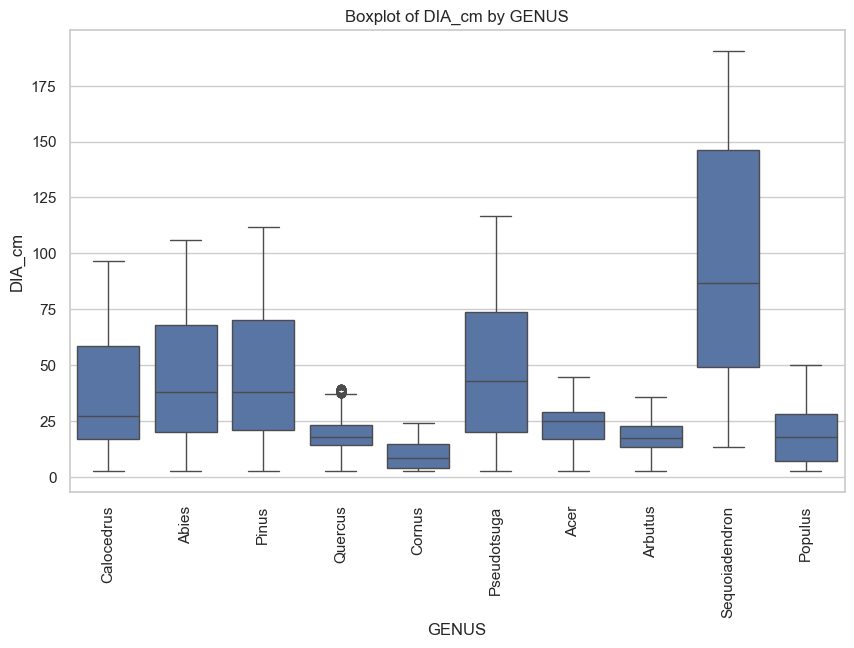

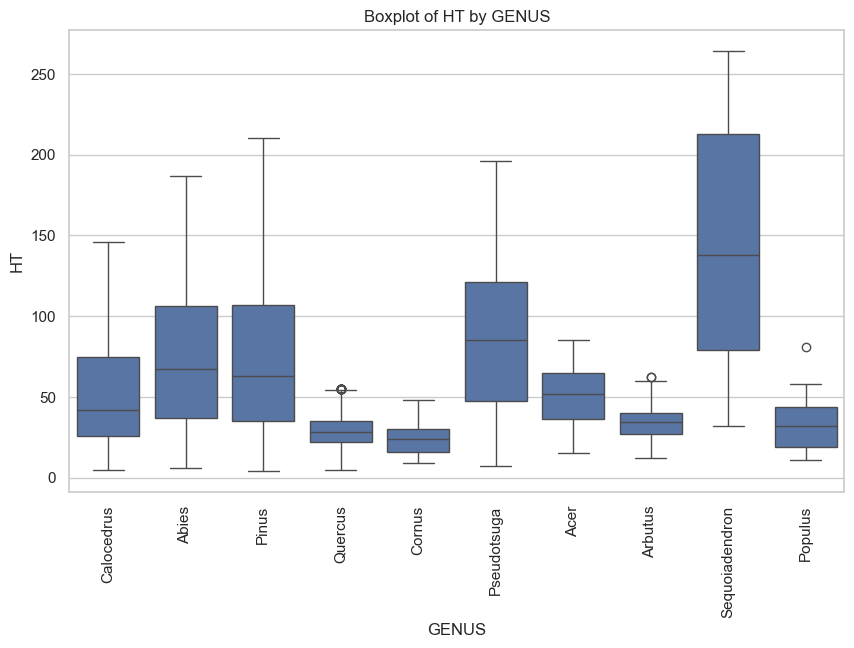

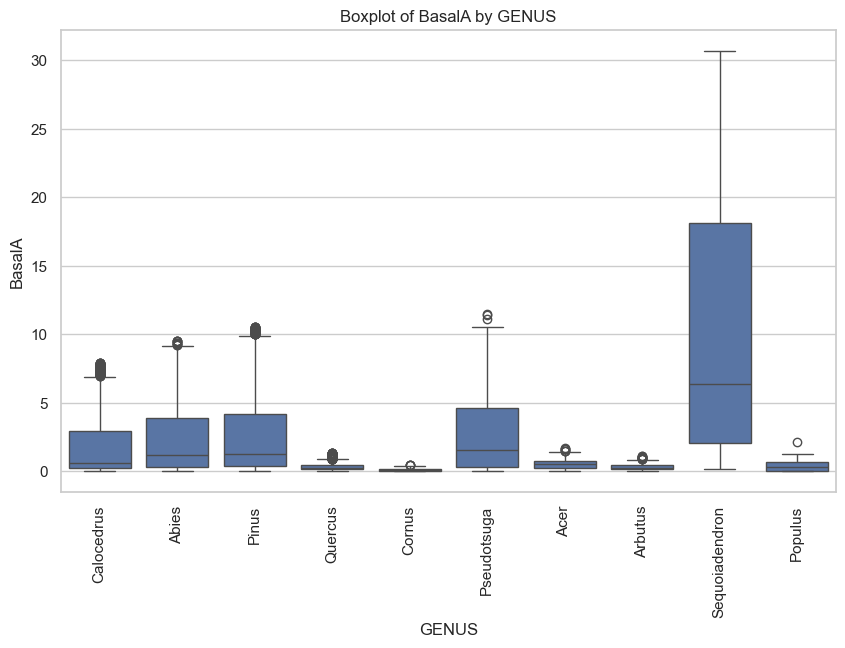

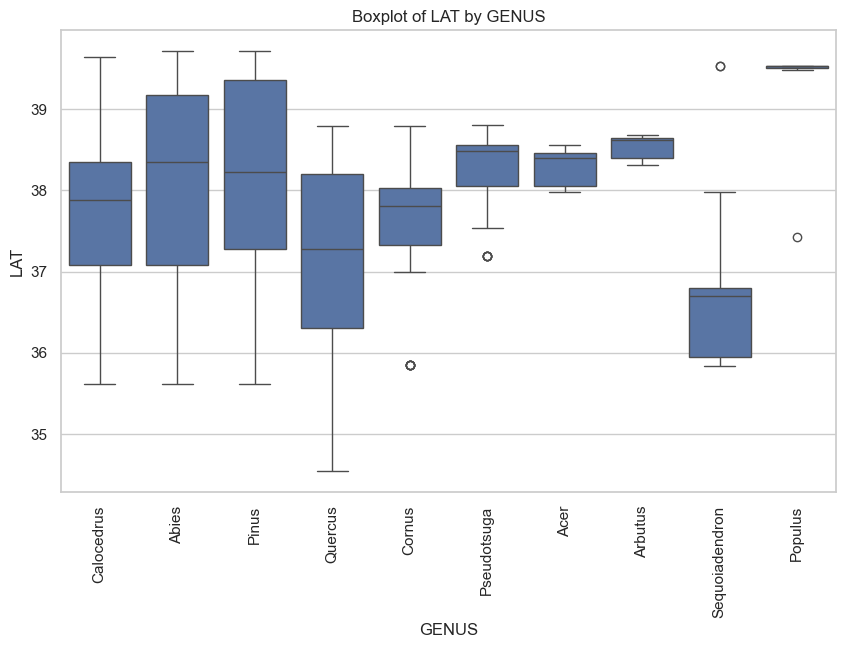

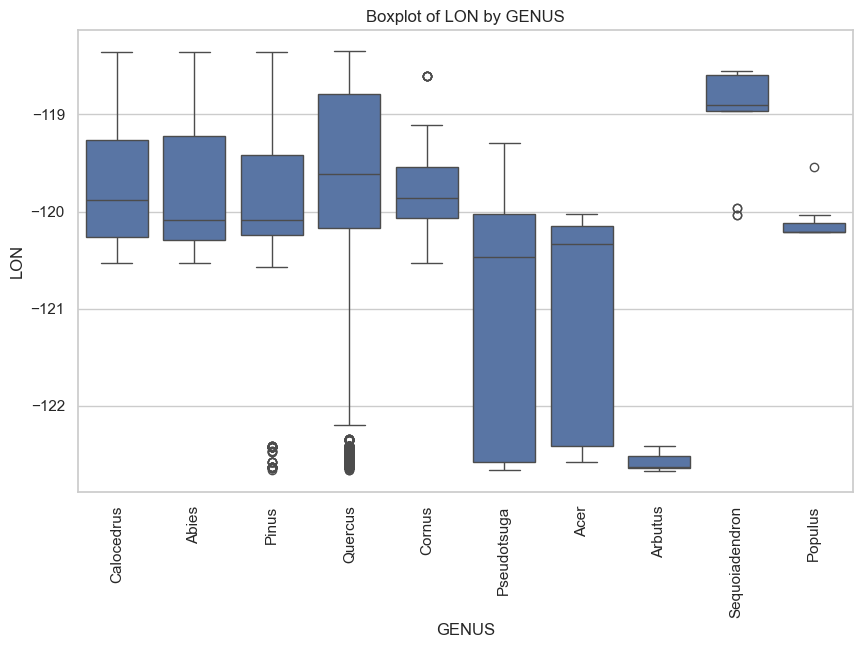

In [822]:
# make box plots to see outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='DIA_cm', data=df_encoded)
plt.xticks(rotation=90)
plt.title('Boxplot of DIA_cm by GENUS')
plt.show()
plt.figure(figsize=(10, 6))

sns.boxplot(x='GENUS', y='HT', data=df_encoded)
plt.xticks(rotation=90)
plt.title('Boxplot of HT by GENUS')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='BasalA', data=df_encoded)
plt.xticks(rotation=90)
plt.title('Boxplot of BasalA by GENUS')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='LAT', data=df_encoded)
plt.xticks(rotation=90)
plt.title('Boxplot of LAT by GENUS')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='LON', data=df_encoded)
plt.xticks(rotation=90)
plt.title('Boxplot of LON by GENUS')
plt.show()


In [823]:
df_encoded

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,1.243602,36.791094,-118.966081,15.0,Evergreen conifer,38.354,False,False,False,False,True,M261Ep,Abies,concolor,white fir
23719,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,False,M261Em,Pinus,ponderosa,ponderosa pine
23720,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,True,M261Ep,Quercus,kelloggii,California black oak
23721,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar


In [824]:
df_encoded['GENUS'].value_counts()

GENUS
Pinus             5767
Abies             4924
Calocedrus        4838
Quercus           4339
Pseudotsuga        626
Arbutus            200
Cornus             115
Acer                73
Sequoiadendron      34
Populus             27
Name: count, dtype: int64

In [825]:
df_encoded.shape

(20943, 17)

In [826]:
df_encoded

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,1.243602,36.791094,-118.966081,15.0,Evergreen conifer,38.354,False,False,False,False,True,M261Ep,Abies,concolor,white fir
23719,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,False,M261Em,Pinus,ponderosa,ponderosa pine
23720,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,True,M261Ep,Quercus,kelloggii,California black oak
23721,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar


In [827]:
df_encoded['SPECIES'].unique()

array(['decurrens', 'concolor', 'lambertiana', 'wislizeni', 'nuttallii',
       'kelloggii', 'magnifica', 'menziesii', 'contorta', 'jeffreyi',
       'chrysolepis', 'ponderosa', 'macrophyllum', 'sabiniana',
       'washoensis', 'giganteum', 'douglasii', 'agrifolia', 'garryana',
       'tremuloides', 'monophylla', 'balsamifera', 'monticola',
       'attenuata', 'lobata', 'coulteri'], dtype=object)

In [828]:
df_encoded['PFT'] = df_encoded['PFT'].astype('category')
df_encoded.head()

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine


In [829]:
df_encoded.columns

Index(['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'SPCD', 'PFT', 'DIA_cm',
       'ECOSUBCD_261Ba', 'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej',
       'ECOSUBCD_M261Em', 'ECOSUBCD_M261Ep', 'ECOSUBCD', 'GENUS', 'SPECIES',
       'COMMON_NAME'],
      dtype='object')

In [830]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
import time

# --- Prepare dataset -----------------------------------------------------------
include_vars = ['DIA_cm', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT', 'GENUS']
df = df_encoded[include_vars].dropna().copy()

from sklearn.preprocessing import OneHotEncoder

# Create the encoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the PFT column (needs to be reshaped for 2D input)
pft_encoded = ohe.fit_transform(df[["PFT"]])

# Convert to DataFrame with appropriate column names
pft_encoded_df = pd.DataFrame(
    pft_encoded,
    columns=[f"PFT_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)

# Drop the original PFT column and join the encoded columns
df = df.drop(columns=["PFT"])
df = pd.concat([df, pft_encoded_df], axis=1)

df.rename(columns={"DIA_cm": "DIA"}, inplace=True)
X = df.drop(columns=["GENUS"])
y = df["GENUS"]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)


# Stratified train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded
)

from sklearn.compose import ColumnTransformer

# Identify numerical and categorical columns again
numerical_cols = ['DIA', 'HT', 'LAT', 'LON']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
    ]
)

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# Concatenate scaled numerical and raw categorical columns
X_train_processed = np.hstack((X_train_scaled, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled, X_test[categorical_cols].values))


In [831]:
X_train

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
19737,37.592,40.0,36.159200,-118.467447,False,False,False,False,0.0,0.0,1.0
11650,27.432,41.0,37.077666,-119.440041,False,False,False,False,0.0,0.0,1.0
6702,14.732,23.0,37.035545,-119.225577,False,False,False,False,0.0,0.0,1.0
2701,18.034,36.0,39.642240,-120.329579,False,False,True,False,0.0,0.0,1.0
3546,28.448,70.0,38.698071,-120.496859,False,False,False,True,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1565,90.932,123.0,36.794307,-118.853624,False,False,False,False,0.0,0.0,1.0
8933,87.630,143.0,36.745188,-118.902737,False,False,False,False,0.0,0.0,1.0
7264,16.002,30.0,35.964888,-118.698143,False,False,False,False,1.0,0.0,0.0
670,26.670,43.0,38.463803,-120.330934,False,False,False,True,1.0,0.0,0.0


In [832]:
print(df_encoded["GENUS"].value_counts())
print("Len :",len(df_encoded["GENUS"].unique()))

GENUS
Pinus             5767
Abies             4924
Calocedrus        4838
Quercus           4339
Pseudotsuga        626
Arbutus            200
Cornus             115
Acer                73
Sequoiadendron      34
Populus             27
Name: count, dtype: int64
Len : 10


In [833]:
X_train_processed.shape

(14660, 11)

In [834]:
X_test_processed.shape

(6283, 11)

In [835]:
from sklearn.utils.class_weight import compute_sample_weight

# Assume X, y_encoded are your full datasets with the same number of rows
assert len(X) == len(y_encoded), "X and y_encoded must have the same number of rows."

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_encoded)

# Check all shapes
print(f"X: {X.shape}, y: {len(y_encoded)}, sample_weights: {len(sample_weights)}")


X: (20943, 11), y: 20943, sample_weights: 20943


In [836]:
X_new = np.hstack((preprocessor.fit_transform(X), X[categorical_cols].values))

In [837]:
X_new

array([[-0.8267943204187193, -0.8538348448559208, -0.27454185962085526,
        ..., 0.0, 0.0, 1.0],
       [-1.3154359714652544, -1.3174986182062653, 0.2930087416049857,
        ..., 0.0, 0.0, 1.0],
       [0.1983950258945999, 0.2022881944420866, -0.6646387066578959, ...,
        0.0, 0.0, 1.0],
       ...,
       [-0.7214010231341724, -0.77655754929753, -1.4328718820997142, ...,
        1.0, 0.0, 0.0],
       [-1.2196238830247574, -1.2402213226478747, -0.6457204717633307,
        ..., 0.0, 0.0, 1.0],
       [2.1337992123926415, 1.5932795144931207, 0.4497626234655112, ...,
        0.0, 0.0, 1.0]], dtype=object)

In [838]:
X_train_processed.shape

(14660, 11)

In [839]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import time
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(zip(np.unique(y_train_encoded), class_weights))
# Define parameter grid for Random Forest
"""rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}"""
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
    'max_depth': [5, 10, 20, 30, 50, 70, 100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Create base model
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Randomized search
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Train the search
rf_random_search.fit(X_train_processed, y_train_encoded)

# Best model
best_rf_model = rf_random_search.best_estimator_

# Evaluate the best RF model
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

train_and_evaluate(best_rf_model, "Tuned Random Forest")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned Random Forest - Accuracy: 0.8268, Training Time: 6.93 seconds
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1477
           1       0.81      0.59      0.68        22
           2       0.83      0.92      0.87        60
           3       0.75      0.85      0.80      1451
           4       0.82      0.89      0.85        35
           5       0.82      0.77      0.79      1730
           6       1.00      0.88      0.93         8
           7       0.75      0.77      0.76       188
           8       0.99      0.99      0.99      1302
           9       0.40      0.40      0.40        10

    accuracy                           0.83      6283
   macro avg       0.80      0.78      0.78      6283
weighted avg       0.83      0.83      0.83      6283

--------------------------------------------------


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 0.4498022598870057,
                                                                  1: 30.043396226415094,
                                                                  2: 9.951875,
                                                                  3: 0.44853521126760565,
                                                                  4: 18.09431818181818,
                                                                  5: 0.38029615476474804,
                                                                  6: 75.82380952380953,
                                                                  7: 3.4766375545851527,
                                                                  8: 0.4144456012493493,
                                                                  9: 66.34583333333333},
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [840]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid for Extra Trees
"""et_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}"""

et_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800],
    'max_depth': [5, 10, 20, 30, 50, 70, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Create ET model
et = ExtraTreesClassifier(random_state=42)

# Randomized search
et_random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=et_param_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit search
et_random_search.fit(X_train_processed, y_train_encoded)
best_et_model = et_random_search.best_estimator_

# Evaluate
train_and_evaluate(best_et_model, "Tuned Extra Trees")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned Extra Trees - Accuracy: 0.8275, Training Time: 6.11 seconds
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1477
           1       0.87      0.59      0.70        22
           2       0.89      0.83      0.86        60
           3       0.76      0.85      0.80      1451
           4       0.79      0.89      0.84        35
           5       0.81      0.78      0.79      1730
           6       1.00      0.88      0.93         8
           7       0.84      0.67      0.75       188
           8       0.99      0.99      0.99      1302
           9       0.60      0.30      0.40        10

    accuracy                           0.83      6283
   macro avg       0.83      0.75      0.78      6283
weighted avg       0.83      0.83      0.83      6283

--------------------------------------------------


In [841]:
from sklearn.tree import DecisionTreeClassifier

# Parameter grid for Decision Tree
"""dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}"""

dt_param_grid = {
    'max_depth': [5, 10, 20, 30, 50, 70, 100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random']
}


# Create DT model
dt = DecisionTreeClassifier(random_state=42)

# Randomized search
dt_random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit search
dt_random_search.fit(X_train_processed, y_train_encoded)
best_dt_model = dt_random_search.best_estimator_

# Evaluate
train_and_evaluate(best_dt_model, "Tuned Decision Tree")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned Decision Tree - Accuracy: 0.7912, Training Time: 0.04 seconds
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1477
           1       0.57      0.59      0.58        22
           2       0.77      0.83      0.80        60
           3       0.73      0.78      0.76      1451
           4       0.77      0.86      0.81        35
           5       0.77      0.73      0.75      1730
           6       1.00      0.88      0.93         8
           7       0.77      0.64      0.70       188
           8       0.98      0.98      0.98      1302
           9       0.75      0.30      0.43        10

    accuracy                           0.79      6283
   macro avg       0.78      0.73      0.75      6283
weighted avg       0.79      0.79      0.79      6283

--------------------------------------------------


In [842]:
from flaml import tune
from flaml.tune import run
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""# Train/Validation split just for tuning meta-learner
X_stack_train, X_stack_val, y_stack_train, y_stack_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.2, random_state=42)
"""
# Base models remain fixed
base_models = [
    ('rf', best_rf_model),
    ('et', best_et_model),
    ('dt', best_dt_model)
]

def train_meta_learner(config):
    model = StackingClassifier(
        estimators=base_models,
        final_estimator=XGBClassifier(
            n_estimators=int(config["n_estimators"]),
            learning_rate=config["learning_rate"],
            max_depth=int(config["max_depth"]),
            min_child_weight=int(config["min_child_weight"]),
            subsample=config["subsample"],
            colsample_bytree=config["colsample_bytree"],
            gamma=config["gamma"],
            reg_alpha=config["reg_alpha"],
            reg_lambda=config["reg_lambda"],
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        cv=5,
        n_jobs=-1
    )
    model.fit(X_train_processed, y_train_encoded)
    preds = model.predict(X_test_processed)
    return {"accuracy": accuracy_score(y_test_encoded, preds)}

# Search space
search_space = {
    "n_estimators": tune.randint(50, 300),
    "learning_rate": tune.loguniform(0.01, 0.3),
    "max_depth": tune.randint(3, 8),
    "min_child_weight": tune.randint(1, 5),
    "subsample": tune.uniform(0.7, 1.0),
    "colsample_bytree": tune.uniform(0.7, 1.0),
    "gamma": tune.uniform(0, 0.3),
    "reg_alpha": tune.uniform(0, 0.1),
    "reg_lambda": tune.uniform(1, 2)
}

# Run FLAML tuner
analysis = tune.run(
    train_meta_learner,
    config=search_space,
    metric="accuracy",
    mode="max",
    num_samples=20,
    time_budget_s=600  # e.g. 10 minutes budget
)

# Get best config
best_config = analysis.get_best_config(metric="accuracy", mode="max")

# Train final stacking model with best XGB config
best_xgb_meta = XGBClassifier(
    **best_config,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_xgb_meta,
    cv=5,
    n_jobs=-1
)

final_stack_model.fit(X_train_processed, y_train_encoded)
train_and_evaluate(final_stack_model, "Stacking with AutoML-tuned XGBoost")


[flaml.tune.tune: 04-13 13:52:14] {589} INFO - Using search algorithm BlendSearch.


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
/Users/ironman/Library/Python/3.9/lib/python/site-packages/flaml/tune/searcher/suggestion.py:886: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return ot.distributions.IntUniformDistribution(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/flaml/tune/searcher/suggestion.py:871: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.Floa

[flaml.tune.tune: 04-13 13:52:14] {891} INFO - trial 1 config: {'n_estimators': 199, 'learning_rate': 0.09038377706605241, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8105978350804359, 'colsample_bytree': 0.9266460694109788, 'gamma': 0.07991772612924071, 'reg_alpha': 0.0756210682605616, 'reg_lambda': 1.01361156664789}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:52:33] {891} INFO - trial 2 config: {'n_estimators': 242, 'learning_rate': 0.010731320001845925, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8495521036907772, 'colsample_bytree': 0.7674389936592543, 'gamma': 0.05941885942788719, 'reg_alpha': 0.07605307121989588, 'reg_lambda': 1.1691108365625356}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 13:52:53] {891} INFO - trial 3 config: {'n_estimators': 72, 'learning_rate': 0.1028867751008824, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.853657679015733, 'colsample_bytree': 0.9437862884956341, 'gamma': 0.18375782004881644, 'reg_alpha': 0.07217553174317996, 'reg_lambda': 1.2918760681706332}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 13:53:13] {891} INFO - trial 4 config: {'n_estimators': 239, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8329376379567311, 'colsample_bytree': 0.7335330150834817, 'gamma': 0.09050178090592302, 'reg_alpha': 0.06360810418770582, 'reg_lambda': 1.2397565744112353}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:53:34] {891} INFO - trial 5 config: {'n_estimators': 242, 'learning_rate': 0.017528470636591312, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8495521036907772, 'colsample_bytree': 0.7674389936592543, 'gamma': 0.05941885942788718, 'reg_alpha': 0.07605307121989588, 'reg_lambda': 1.1691108365625356}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:53:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:53:55] {891} INFO - trial 6 config: {'n_estimators': 221, 'learning_rate': 0.010129838487051129, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8626041810918653, 'colsample_bytree': 0.7, 'gamma': 0.13214250821131207, 'reg_alpha': 0.07343691678796792, 'reg_lambda': 1.379703120020688}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:54:16] {891} INFO - trial 7 config: {'n_estimators': 257, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.803271094821597, 'colsample_bytree': 0.7752735147819932, 'gamma': 0.04886105360053397, 'reg_alpha': 0.053779291587443726, 'reg_lambda': 1.0998100288017827}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:54:36] {891} INFO - trial 8 config: {'n_estimators': 198, 'learning_rate': 0.08672364246008264, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8350397036934162, 'colsample_bytree': 0.8705392242784638, 'gamma': 0.07316726553658681, 'reg_alpha': 0.07305714042256838, 'reg_lambda': 1.1369207706133704}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:54:56] {891} INFO - trial 9 config: {'n_estimators': 279, 'learning_rate': 0.11363577488646587, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8120022280154408, 'colsample_bytree': 0.9022400845199036, 'gamma': 0.1325499523268988, 'reg_alpha': 0.04340139933332937, 'reg_lambda': 1.6177669784693172}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 13:55:16] {891} INFO - trial 10 config: {'n_estimators': 271, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8166189448795398, 'colsample_bytree': 0.7420532565217346, 'gamma': 0.11694032361633813, 'reg_alpha': 0.06890512549258966, 'reg_lambda': 1.2703240403005782}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:55:37] {891} INFO - trial 11 config: {'n_estimators': 178, 'learning_rate': 0.09135146183055094, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8564941457180902, 'colsample_bytree': 0.9725946642426004, 'gamma': 0.09577082669656357, 'reg_alpha': 0.009045934927090738, 'reg_lambda': 1.3007000566362033}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 13:55:57] {891} INFO - trial 12 config: {'n_estimators': 207, 'learning_rate': 0.015315463409824344, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8492563310339225, 'colsample_bytree': 0.7250127736452288, 'gamma': 0.0640632381955079, 'reg_alpha': 0.058311082882821975, 'reg_lambda': 1.2091891085218924}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:56:17] {891} INFO - trial 13 config: {'n_estimators': 250, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7747041790905798, 'colsample_bytree': 0.7280403716139899, 'gamma': 0.0882200988316518, 'reg_alpha': 0.05669712161642243, 'reg_lambda': 1.2290990275175337}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:56:38] {891} INFO - trial 14 config: {'n_estimators': 200, 'learning_rate': 0.09419838610314382, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7861559664674557, 'colsample_bytree': 0.9827529145434939, 'gamma': 0.0866681867218946, 'reg_alpha': 0.07818499609855484, 'reg_lambda': 1}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:56:57] {891} INFO - trial 15 config: {'n_estimators': 78, 'learning_rate': 0.1675185096049461, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8642758467757731, 'colsample_bytree': 0.9457860987010206, 'gamma': 0.05968426190364368, 'reg_alpha': 0.08568503024577333, 'reg_lambda': 1.3516526394320878}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 13:57:16] {891} INFO - trial 16 config: {'n_estimators': 228, 'learning_rate': 0.013345847497642596, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8911710968228825, 'colsample_bytree': 0.7390256585529734, 'gamma': 0.09278346298019424, 'reg_alpha': 0.0705190867589892, 'reg_lambda': 1.250414121304937}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:57:36] {891} INFO - trial 17 config: {'n_estimators': 242, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8518629620485707, 'colsample_bytree': 0.7132086511721604, 'gamma': 0.055260279923043595, 'reg_alpha': 0.08594103681267884, 'reg_lambda': 1.179592491238462}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:57:57] {891} INFO - trial 18 config: {'n_estimators': 236, 'learning_rate': 0.010947197679063034, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8140123138648916, 'colsample_bytree': 0.753857378994803, 'gamma': 0.12574328188880246, 'reg_alpha': 0.0412751715627328, 'reg_lambda': 1.2999206575840085}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:58:17] {891} INFO - trial 19 config: {'n_estimators': 226, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8099162494370733, 'colsample_bytree': 0.7582617493858405, 'gamma': 0.10831528856738155, 'reg_alpha': 0.05550473172875303, 'reg_lambda': 1.3012147003567167}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 13:58:37] {891} INFO - trial 20 config: {'n_estimators': 239, 'learning_rate': 0.020614687174103818, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8329376379567311, 'colsample_bytree': 0.7335330150834817, 'gamma': 0.09050178090592302, 'reg_alpha': 0.06360810418770582, 'reg_lambda': 1.2397565744112353}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:58:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking with AutoML-tuned XGBoost - Accuracy: 0.8276, Training Time: 20.52 seconds
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1477
           1       0.81      0.59      0.68        22
           2       0.88      0.77      0.82        60
           3       0.76      0.83      0.80      1451
           4       0.79      0.89      0.84        35
           5       0.81      0.77      0.79      1730
           6       1.00      0.88      0.93         8
           7       0.79      0.75      0.77       188
           8       0.98      0.99      0.99      1302
           9       0.43      0.30      0.35        10

    accuracy                           0.83      6283
   macro avg       0.81      0.75      0.77      6283
weighted avg       0.83      0.83      0.83      6283

--------------------------------------------------


In [843]:
best_config

{'n_estimators': 226,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 3,
 'subsample': 0.8099162494370733,
 'colsample_bytree': 0.7582617493858405,
 'gamma': 0.10831528856738155,
 'reg_alpha': 0.05550473172875303,
 'reg_lambda': 1.3012147003567167}

In [844]:
final_stack_model

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 0.4252973600232086,
                                                                     1: 28.745098039215687,
                                                                     2: 10.471428571428572,
                                                                     3: 0.4328314142308828,
                                                                     4: 18.325,
                                                                     5: 0.36314094624721327,
                                                                     6: 77.15789473684211,
                                                                     7: 3.34703196347032,
                                                                     8: 0.4827132038195588,
                                                                     9: 61.083333333333336},
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_split=5,
                                                       n_estimators=800,
                                                       ran...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=6, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=226, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=-1)

In [845]:
final_stack_model.get_params()

{'cv': 5,
 'estimators': [('rf',
   RandomForestClassifier(class_weight={0: 0.4252973600232086,
                                        1: 28.745098039215687,
                                        2: 10.471428571428572,
                                        3: 0.4328314142308828, 4: 18.325,
                                        5: 0.36314094624721327,
                                        6: 77.15789473684211, 7: 3.34703196347032,
                                        8: 0.4827132038195588,
                                        9: 61.083333333333336},
                          criterion='entropy', max_depth=100, min_samples_split=5,
                          n_estimators=800, random_state=42)),
  ('et',
   ExtraTreesClassifier(criterion='entropy', max_depth=30, max_features=None,
                        min_samples_leaf=2, n_estimators=800, random_state=42)),
  ('dt',
   DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2,
                          

In [846]:
#stacking_model.fit(X_new,y_encoded, sample_weight=sample_weights)
#best_stack_model.fit(X_new,y_encoded, sample_weight=sample_weights)
#best_stack_xgb_model.fit(X_new,y_encoded, sample_weight=sample_weights)
final_stack_model.fit(X_new,y_encoded, sample_weight=sample_weights)

/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 0.4252973600232086,
                                                                     1: 28.745098039215687,
                                                                     2: 10.471428571428572,
                                                                     3: 0.4328314142308828,
                                                                     4: 18.325,
                                                                     5: 0.36314094624721327,
                                                                     6: 77.15789473684211,
                                                                     7: 3.34703196347032,
                                                                     8: 0.4827132038195588,
                                                                     9: 61.083333333333336},
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_split=5,
                                                       n_estimators=800,
                                                       ran...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=6, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=226, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=-1)

In [847]:
X_train

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
19737,37.592,40.0,36.159200,-118.467447,False,False,False,False,0.0,0.0,1.0
11650,27.432,41.0,37.077666,-119.440041,False,False,False,False,0.0,0.0,1.0
6702,14.732,23.0,37.035545,-119.225577,False,False,False,False,0.0,0.0,1.0
2701,18.034,36.0,39.642240,-120.329579,False,False,True,False,0.0,0.0,1.0
3546,28.448,70.0,38.698071,-120.496859,False,False,False,True,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1565,90.932,123.0,36.794307,-118.853624,False,False,False,False,0.0,0.0,1.0
8933,87.630,143.0,36.745188,-118.902737,False,False,False,False,0.0,0.0,1.0
7264,16.002,30.0,35.964888,-118.698143,False,False,False,False,1.0,0.0,0.0
670,26.670,43.0,38.463803,-120.330934,False,False,False,True,1.0,0.0,0.0


In [848]:
X 

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
0,15.494,25.0,37.514660,-119.737508,False,False,False,False,0.0,0.0,1.0
1,2.540,7.0,38.153364,-120.059054,False,False,False,True,0.0,0.0,1.0
2,42.672,66.0,37.075657,-119.382396,False,False,False,False,0.0,0.0,1.0
3,43.688,49.0,38.605369,-120.371609,False,False,False,True,0.0,0.0,1.0
4,19.812,40.0,37.370380,-119.540933,False,False,False,False,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
23718,38.354,93.0,36.791094,-118.966081,False,False,False,False,0.0,0.0,1.0
23719,44.704,57.0,38.001863,-120.030085,False,False,False,True,0.0,0.0,1.0
23720,18.288,28.0,36.211111,-118.657481,False,False,False,False,1.0,0.0,0.0
23721,5.080,10.0,37.096947,-119.360283,False,False,False,False,0.0,0.0,1.0


In [849]:
y 

0        Calocedrus
1             Abies
2        Calocedrus
3        Calocedrus
4             Pinus
            ...    
23718         Abies
23719         Pinus
23720       Quercus
23721    Calocedrus
23723         Pinus
Name: GENUS, Length: 20943, dtype: object

In [850]:
TLS_X

,DIA_cm,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,predicted_PFT
0,20.987379,12.560,2.402324,0.000019,-121.488648,False,False,False,False,M261Ep,Evergreen broadleaf
1,13.105771,8.742,0.936786,0.000010,-121.488722,False,False,False,False,M261Ep,Evergreen broadleaf
2,59.840890,13.469,19.530404,0.000009,-121.488725,False,False,False,False,M261Ep,Evergreen broadleaf
3,21.040854,18.144,2.414582,0.000079,-121.488726,False,False,False,False,M261Ep,Evergreen conifer
4,16.390056,13.790,1.465130,0.000002,-121.488731,False,False,False,False,M261Ep,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,1.636854,0.000025,-127.488832,False,False,False,True,M261Em,Evergreen conifer
1378,24.252048,23.077,3.207835,-0.000084,-127.488726,False,False,False,True,M261Em,Evergreen conifer
1379,17.835430,30.127,1.734931,0.000062,-127.488817,False,False,False,True,M261Em,Evergreen conifer
1380,14.208700,29.300,1.101093,-0.000074,-127.488768,False,False,False,True,M261Em,Evergreen conifer


In [851]:
TLS_X.drop(columns=['BasalA'], inplace=True)

In [852]:
TLS_X.drop(columns=['ECOSUBCD'], inplace=True)

In [853]:
TLS_X

,DIA_cm,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,predicted_PFT
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,Evergreen broadleaf
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,Evergreen broadleaf
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,Evergreen broadleaf
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,Evergreen conifer
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,Evergreen conifer
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,Evergreen conifer
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,Evergreen conifer
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,Evergreen conifer


In [854]:
#TLS_X.drop(columns=['predicted_genus'], inplace=True)

In [855]:
TLS_X.columns = ['DIA', 'HT', 'LAT', 'LON','ECOSUBCD_261Ba','ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT']

In [856]:
TLS_X

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,Evergreen broadleaf
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,Evergreen broadleaf
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,Evergreen broadleaf
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,Evergreen conifer
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,Evergreen conifer
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,Evergreen conifer
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,Evergreen conifer
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,Evergreen conifer


In [857]:
# One-hot encode the PFT column
PFT_encoded = pd.get_dummies(TLS_X['PFT'], prefix='PFT')

# Concatenate the one-hot encoded columns with the original DataFrame
TLS_X = pd.concat([TLS_X, PFT_encoded], axis=1)

# Drop the original PFT column
TLS_X.drop(columns=['PFT'], inplace=True)

# Display the updated DataFrame
TLS_X.head()

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False


In [858]:
TLS_X

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True


In [859]:
TLS_X['PFT_Evergreen broadleaf'] = ~TLS_X['PFT_Deciduous broadleaf'] & ~TLS_X['PFT_Evergreen conifer']

In [860]:
#TLS_X.drop(columns=["PFT_Evergreen broadleaf"], inplace=True)

In [861]:
X_train.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer'],
      dtype='object')

In [862]:
TLS_X_new = np.hstack((preprocessor.fit_transform(TLS_X), TLS_X[categorical_cols].values))

In [863]:
pred =  final_stack_model.predict(TLS_X_new)

In [864]:
predicted_genus = le.inverse_transform(pred)

In [865]:
predicted_genus

array(['Quercus', 'Quercus', 'Quercus', ..., 'Abies', 'Pinus',
       'Calocedrus'], dtype=object)

In [866]:
pred 

array([8, 8, 8, ..., 0, 5, 3])

In [867]:
TLS_X['predicted_genus'] = predicted_genus.copy()

In [868]:
TLS_X 

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus


In [869]:
TLS_X['predicted_genus'].value_counts()

predicted_genus
Pinus          380
Quercus        267
Abies          264
Calocedrus     193
Pseudotsuga    169
Acer            13
Name: count, dtype: int64

In [870]:
df_field[['GENUS', 'SPECIES']] = df_field['tree_sp_scientific_name'].str.split(' ', n=1, expand=True)
df_field.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT,ECOSUBCD,GENUS,SPECIES
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor


In [871]:
df_encoded['GENUS'].value_counts(normalize=True) * 100

GENUS
Pinus             27.536647
Abies             23.511436
Calocedrus        23.100797
Quercus           20.718140
Pseudotsuga        2.989066
Arbutus            0.954973
Cornus             0.549109
Acer               0.348565
Sequoiadendron     0.162345
Populus            0.128921
Name: proportion, dtype: float64

In [872]:
# find percentage of each predicted genus
predicted_genus_counts = TLS_X['predicted_genus'].value_counts(normalize=True) * 100
# Display the percentage of each predicted genus
print("Percentage of each predicted genus:")
print(predicted_genus_counts)

Percentage of each predicted genus:
predicted_genus
Pinus          29.548989
Quercus        20.762053
Abies          20.528771
Calocedrus     15.007776
Pseudotsuga    13.141524
Acer            1.010886
Name: proportion, dtype: float64


In [873]:
df_field['GENUS'].value_counts(normalize=True) * 100

GENUS
Abies             23.800652
Calocedrus        22.263624
Quercus           21.471821
Pinus             18.258034
Pseudotsuga        5.263158
Arbutus            3.213787
Notholicarpos      2.980904
Populus            1.071262
Salix              0.791803
Cornus             0.558919
Sequoiadendron     0.232883
Acer               0.093153
Name: proportion, dtype: float64

In [874]:
TLS_X

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus


In [875]:
df_field["GENUS"].unique()

array(['Abies', 'Calocedrus', 'Salix', 'Pinus', 'Cornus', 'Populus',
       'Quercus', 'Sequoiadendron', 'Acer', 'Pseudotsuga', 'Arbutus',
       'Notholicarpos'], dtype=object)

In [876]:
"""
# save the model as pickle file
import pickle
filename = 'final_genus_model.pkl'
pickle.dump(final_stack_model, open(filename, 'wb'))
"""

"\n# save the model as pickle file\nimport pickle\nfilename = 'final_genus_model.pkl'\npickle.dump(final_stack_model, open(filename, 'wb'))\n"

In [877]:
TLS_X 

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus


In [878]:
# Save TLS_X DataFrame to CSV
TLS_X.to_csv("TLS_X_Genus.csv", index=False)

## SPECIES

In [879]:
TLS_species = TLS_X.copy()

In [880]:
df_encoded_species = df_encoded.copy()

In [881]:
df_encoded_species['SPECIES'].value_counts(normalize=True) * 100

SPECIES
decurrens       23.100797
concolor        21.200401
ponderosa       13.216827
chrysolepis      9.630903
jeffreyi         7.725732
kelloggii        5.123430
lambertiana      4.631619
menziesii        3.944039
wislizeni        2.616626
magnifica        2.311035
agrifolia        1.527957
garryana         1.122093
contorta         0.897675
douglasii        0.654157
nuttallii        0.549109
washoensis       0.424963
sabiniana        0.391539
macrophyllum     0.348565
giganteum        0.162345
tremuloides      0.124146
monophylla       0.124146
monticola        0.100272
lobata           0.042974
attenuata        0.019099
balsamifera      0.004775
coulteri         0.004775
Name: proportion, dtype: float64

In [882]:
df_encoded_species


,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,False,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,False,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,True,M261Ep,Pinus,lambertiana,sugar pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,1.243602,36.791094,-118.966081,15.0,Evergreen conifer,38.354,False,False,False,False,True,M261Ep,Abies,concolor,white fir
23719,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,False,M261Em,Pinus,ponderosa,ponderosa pine
23720,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,True,M261Ep,Quercus,kelloggii,California black oak
23721,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,True,M261Ep,Calocedrus,decurrens,incense-cedar


In [883]:
df_encoded_species.isna().sum()

DIA                0
HT                 0
BasalA             0
LAT                0
LON                0
SPCD               0
PFT                0
DIA_cm             0
ECOSUBCD_261Ba     0
ECOSUBCD_263Am     0
ECOSUBCD_M261Ej    0
ECOSUBCD_M261Em    0
ECOSUBCD_M261Ep    0
ECOSUBCD           0
GENUS              0
SPECIES            0
COMMON_NAME        0
dtype: int64

In [884]:
# Split the 'tree_sp_scientific_name' column into two new columns using regex
tree_data = pd.read_csv("Field/03_tree.csv", low_memory=False)
tree_data[['GENUS_NEW', 'SPECIES_NEW']] = tree_data['tree_sp_scientific_name'].str.extract(r'(\S+)\s+(.*)')

# Display the updated dataframe
tree_data.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,tree_decay_class,tree_decay_class_label,treepost_scorch_m,treepost_scorch_per,treepost_torch_m,treepost_torch_per,treepost_bole_char_m,tree_notes,GENUS_NEW,SPECIES_NEW
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor


In [885]:
tree_data['SPECIES_NEW'].value_counts()

SPECIES_NEW
decurrens       478
concolor        449
agrifolia       307
menziesii       182
contorta        178
jeffreyi        120
kelloggii        75
densiflorus      64
magnifica        62
ponderosa        59
douglasii        52
lambertiana      35
tremuloides      23
chrysolepis      20
sp.              16
nuttalii         12
lobata            6
giganteum         5
scouleriana       2
glabrum           1
macrophyllum      1
Name: count, dtype: int64

In [886]:
# List of genera to keep
species_to_keep = ['decurrens', 'concolor', 'agrifolia', 'menziesii', 'jeffreyi',
                  'kelloggii', 'densiflorus', 'magnificar', 'ponderosa', 'douglasii',
                  'lambertiana', 'tremuloides', 'chrysolepis', 'sp.', 'nuttalii', 'lobata', 'giganteum', 'scouleriana', 'glabrum', 'macrophyllum']

# Filter the DataFrame
df_encoded_species = df_encoded_species[df_encoded_species["SPECIES"].isin(species_to_keep)].copy()
df_encoded_species.shape

(19149, 17)

In [887]:
df_encoded_species['SPECIES'].value_counts()

SPECIES
decurrens       4838
concolor        4440
ponderosa       2768
chrysolepis     2017
jeffreyi        1618
kelloggii       1073
lambertiana      970
menziesii        826
agrifolia        320
douglasii        137
macrophyllum      73
giganteum         34
tremuloides       26
lobata             9
Name: count, dtype: int64

In [888]:
#make a class called OTHER out of all the columns in df_encoded_species except decurrens, concolor, pondoresa, chrysolepis, kelloggii and jeffreyi
# List of species to keep
# Modify the list to also include those columns from tree_data whose percentage distribution is greater than 
# species_to_keep = ['decurrens', 'concolor', 'ponderosa', 'chrysolepis', 'kelloggii', 'jeffreyi', 'grifolia', 'menziesii','contorta','agrifolia']
# # List of species to replace with 'OTHER'
# species_to_replace = df_encoded_species['SPECIES'].unique().tolist()
# species_to_replace = [species for species in species_to_replace if species not in species_to_keep]
# # Replace the species names
# df_encoded_species['SPECIES'] = df_encoded_species['SPECIES'].replace(species_to_replace, 'OTHER')
# df_encoded_species['SPECIES'].value_counts()

In [889]:
def remove_outliers_by_species(df, column, group_by):
    df_clean = df.copy()
    iteration = 0
    while True:
        iteration += 1
        Q1 = df_clean.groupby(group_by)[column].transform('quantile', 0.25)
        Q3 = df_clean.groupby(group_by)[column].transform('quantile', 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Keep rows within bounds
        mask = (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)

        prev_shape = df_clean.shape[0]
        df_clean = df_clean[mask]
        new_shape = df_clean.shape[0]

        # If no further rows are removed, break
        if new_shape == prev_shape:
            print(f"No more outliers detected after {iteration} iterations.")
            break
        else:
            print(f"Iteration {iteration}: Removed {prev_shape - new_shape} rows.")

    return df_clean

# Apply this function
df_encoded_species = remove_outliers_by_species(df_encoded_species, 'DIA', 'SPECIES')

# Check resulting shape
print(f"Shape after removing all outliers: {df_encoded_species.shape}")


Iteration 1: Removed 59 rows.
Iteration 2: Removed 54 rows.
Iteration 3: Removed 30 rows.
No more outliers detected after 4 iterations.
Shape after removing all outliers: (19006, 17)


In [890]:
# Remove outliers in DIA based on GENUS
df_encoded_species = remove_outliers_by_species(df_encoded_species, 'BasalA', 'SPECIES')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded_species.shape}")

Iteration 1: Removed 345 rows.
Iteration 2: Removed 268 rows.
Iteration 3: Removed 232 rows.
Iteration 4: Removed 335 rows.
Iteration 5: Removed 598 rows.
Iteration 6: Removed 368 rows.
Iteration 7: Removed 260 rows.
Iteration 8: Removed 163 rows.
Iteration 9: Removed 128 rows.
Iteration 10: Removed 80 rows.
Iteration 11: Removed 46 rows.
Iteration 12: Removed 36 rows.
Iteration 13: Removed 18 rows.
Iteration 14: Removed 5 rows.
No more outliers detected after 15 iterations.
Shape after removing outliers: (16124, 17)


In [891]:
# Remove outliers in DIA based on GENUS
df_encoded_species = remove_outliers_by_species(df_encoded_species, 'HT', 'SPECIES')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded_species.shape}")

Iteration 1: Removed 70 rows.
No more outliers detected after 2 iterations.
Shape after removing outliers: (16054, 17)


In [892]:
# Remove outliers in DIA based on GENUS
df_encoded_species = remove_outliers_by_species(df_encoded_species, 'LAT', 'SPECIES')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded_species.shape}")

Iteration 1: Removed 347 rows.
Iteration 2: Removed 166 rows.
No more outliers detected after 3 iterations.
Shape after removing outliers: (15541, 17)


In [893]:
# Remove outliers in DIA based on GENUS
df_encoded_species = remove_outliers_by_species(df_encoded_species, 'LON', 'SPECIES')

# Check the resulting shape
print(f"Shape after removing outliers: {df_encoded_species.shape}")

Iteration 1: Removed 78 rows.
No more outliers detected after 2 iterations.
Shape after removing outliers: (15463, 17)


In [894]:
df_encoded_species['SPECIES'].value_counts(normalize=True) * 100

SPECIES
concolor        28.649033
decurrens       18.534566
ponderosa       17.674449
chrysolepis     10.935782
kelloggii        6.273039
lambertiana      6.208368
jeffreyi         4.100110
menziesii        4.035439
agrifolia        2.037121
douglasii        0.743711
macrophyllum     0.426825
giganteum        0.194012
tremuloides      0.129341
lobata           0.058203
Name: proportion, dtype: float64

In [895]:
tree_data['SPECIES_NEW'].value_counts(normalize=True) * 100

SPECIES_NEW
decurrens       22.263624
concolor        20.912902
agrifolia       14.299022
menziesii        8.476945
contorta         8.290638
jeffreyi         5.589194
kelloggii        3.493246
densiflorus      2.980904
magnifica        2.887750
ponderosa        2.748020
douglasii        2.421984
lambertiana      1.630182
tremuloides      1.071262
chrysolepis      0.931532
sp.              0.745226
nuttalii         0.558919
lobata           0.279460
giganteum        0.232883
scouleriana      0.093153
glabrum          0.046577
macrophyllum     0.046577
Name: proportion, dtype: float64

In [896]:
check = pd.read_csv("X_y.csv", low_memory=False)

In [897]:
check["GENUS"].value_counts(normalize=True) * 100

GENUS
Pinus             27.676329
Abies             23.739130
Calocedrus        22.913043
Quercus           20.589372
Pseudotsuga        3.009662
Arbutus            0.927536
Cornus             0.536232
Acer               0.318841
Sequoiadendron     0.164251
Populus            0.125604
Name: proportion, dtype: float64

In [898]:
check

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,GENUS
0,15.494,25.0,37.514660,-119.737508,False,False,False,False,0.0,0.0,1.0,Calocedrus
1,2.540,7.0,38.153364,-120.059054,False,False,False,True,0.0,0.0,1.0,Abies
2,42.672,66.0,37.075657,-119.382396,False,False,False,False,0.0,0.0,1.0,Calocedrus
3,43.688,49.0,38.605369,-120.371609,False,False,False,True,0.0,0.0,1.0,Calocedrus
4,19.812,40.0,37.370380,-119.540933,False,False,False,False,0.0,0.0,1.0,Pinus
...,...,...,...,...,...,...,...,...,...,...,...,...
20695,38.354,93.0,36.791094,-118.966081,False,False,False,False,0.0,0.0,1.0,Abies
20696,44.704,57.0,38.001863,-120.030085,False,False,False,True,0.0,0.0,1.0,Pinus
20697,18.288,28.0,36.211111,-118.657481,False,False,False,False,1.0,0.0,0.0,Quercus
20698,5.080,10.0,37.096947,-119.360283,False,False,False,False,0.0,0.0,1.0,Calocedrus


In [899]:
TLS_species["predicted_genus"].value_counts(normalize=True) * 100

predicted_genus
Pinus          29.548989
Quercus        20.762053
Abies          20.528771
Calocedrus     15.007776
Pseudotsuga    13.141524
Acer            1.010886
Name: proportion, dtype: float64

In [900]:
df_encoded_species.to_csv("df_encoded_species.csv", index=False)

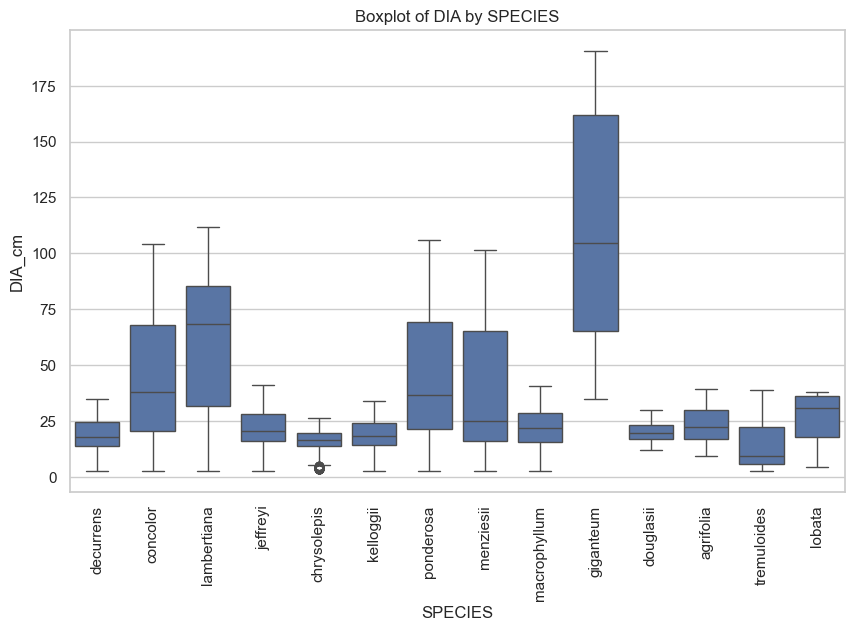

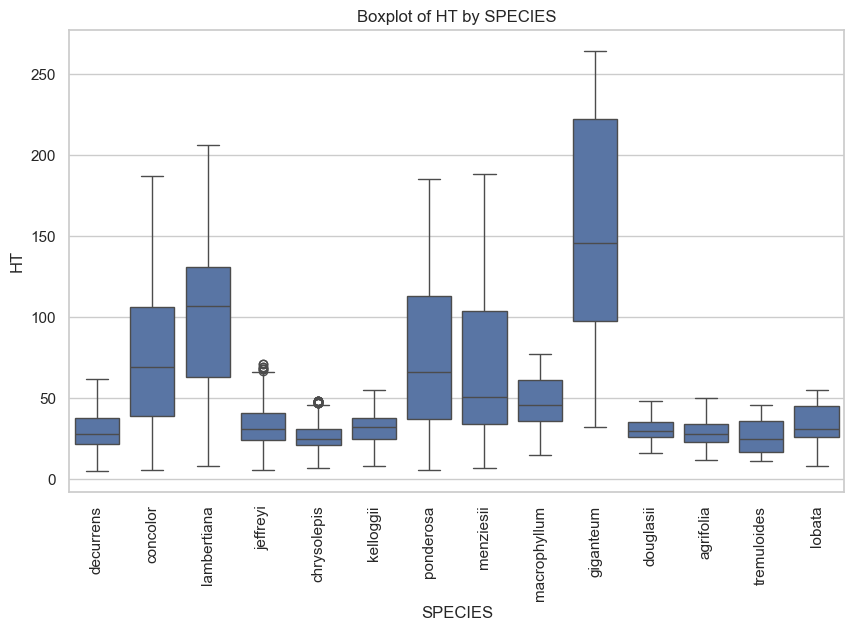

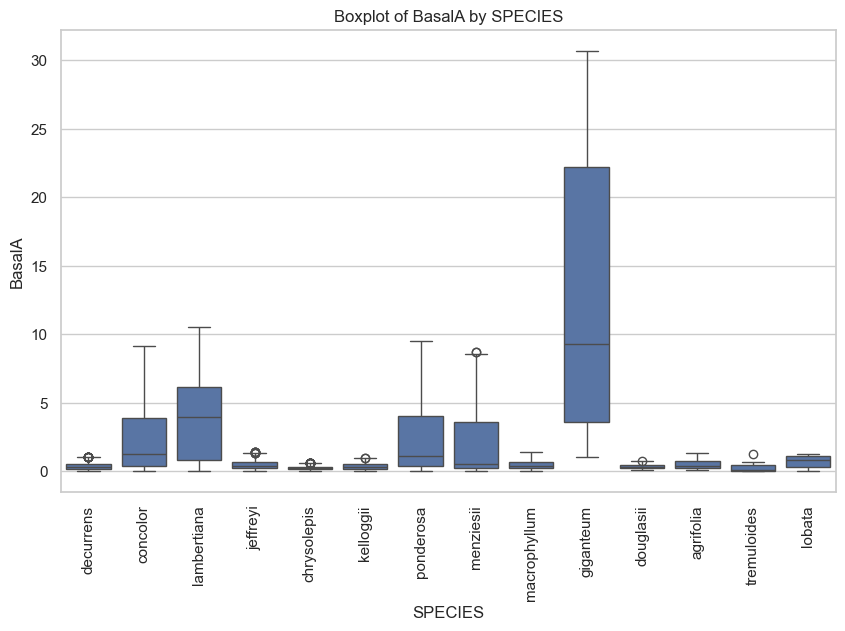

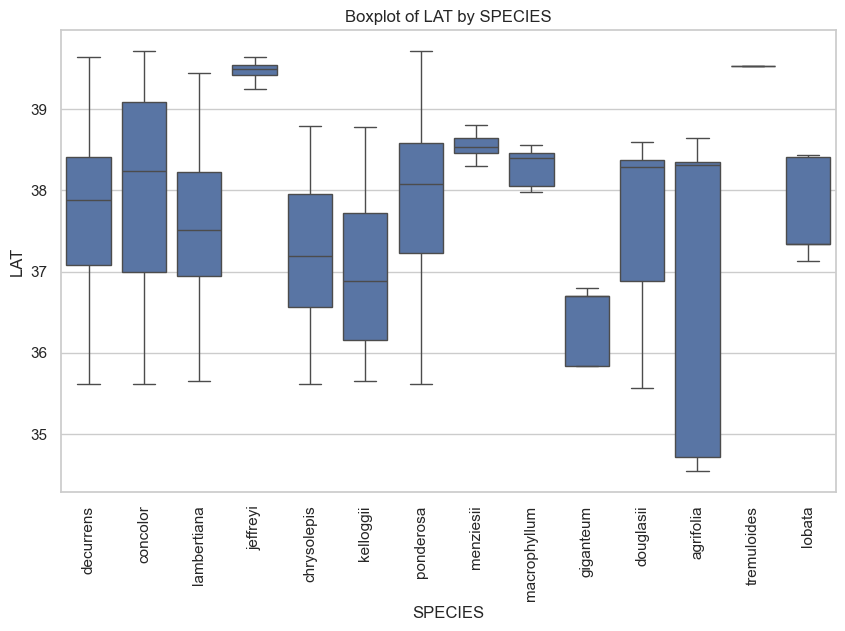

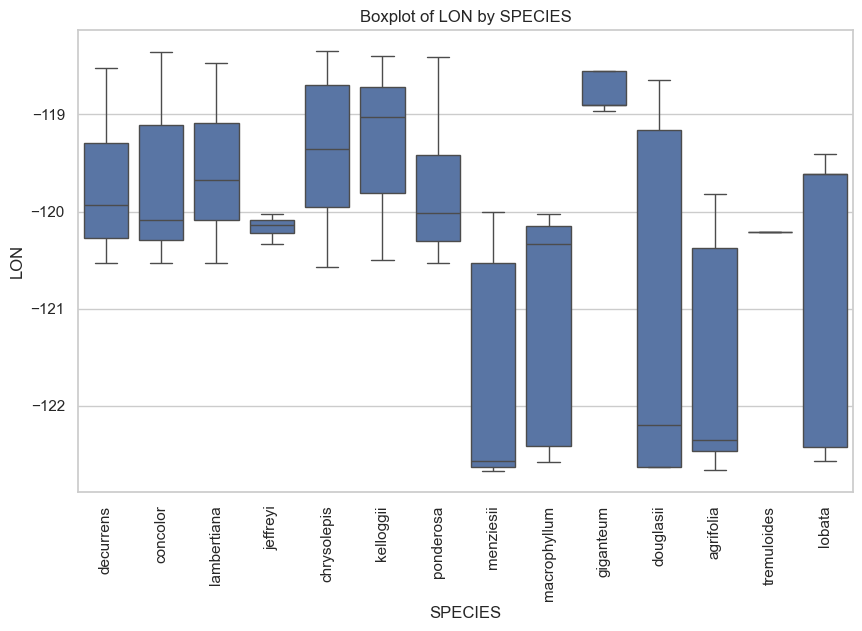

In [901]:
# make box plots to see outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='DIA_cm', data=df_encoded_species)
plt.xticks(rotation=90)
plt.title('Boxplot of DIA by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))

sns.boxplot(x='SPECIES', y='HT', data=df_encoded_species)
plt.xticks(rotation=90)
plt.title('Boxplot of HT by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='BasalA', data=df_encoded_species)
plt.xticks(rotation=90)
plt.title('Boxplot of BasalA by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='LAT', data=df_encoded_species)
plt.xticks(rotation=90)
plt.title('Boxplot of LAT by SPECIES')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='LON', data=df_encoded_species)
plt.xticks(rotation=90)
plt.title('Boxplot of LON by SPECIES')
plt.show()

In [902]:
# Filter the DataFrame to include only rows where GENUS is 'Abies' or 'Pinus'
df_encoded_filtered = df_encoded_species[df_encoded_species['SPECIES'].isin(['menziesii', 'agrifolia'])]

# Display the filtered DataFrame
df_encoded_filtered.head()

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD_M261Ep,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
41,5.4,41.0,0.159043,38.536772,-122.633328,202.0,Evergreen conifer,13.716,False,True,False,False,False,263Am,Pseudotsuga,menziesii,Douglas-fir
43,26.5,85.0,3.830180,38.516063,-122.465583,202.0,Evergreen conifer,67.310,False,True,False,False,False,263Am,Pseudotsuga,menziesii,Douglas-fir
76,8.4,47.0,0.384845,38.536772,-122.633328,202.0,Evergreen conifer,21.336,False,True,False,False,False,263Am,Pseudotsuga,menziesii,Douglas-fir
81,1.7,14.0,0.015763,38.648632,-122.664556,361.0,Evergreen broadleaf,4.318,False,True,False,False,False,263Am,Arbutus,menziesii,Pacific madrone
112,9.9,39.0,0.534562,38.349716,-122.483142,361.0,Evergreen broadleaf,25.146,False,True,False,False,False,263Am,Arbutus,menziesii,Pacific madrone


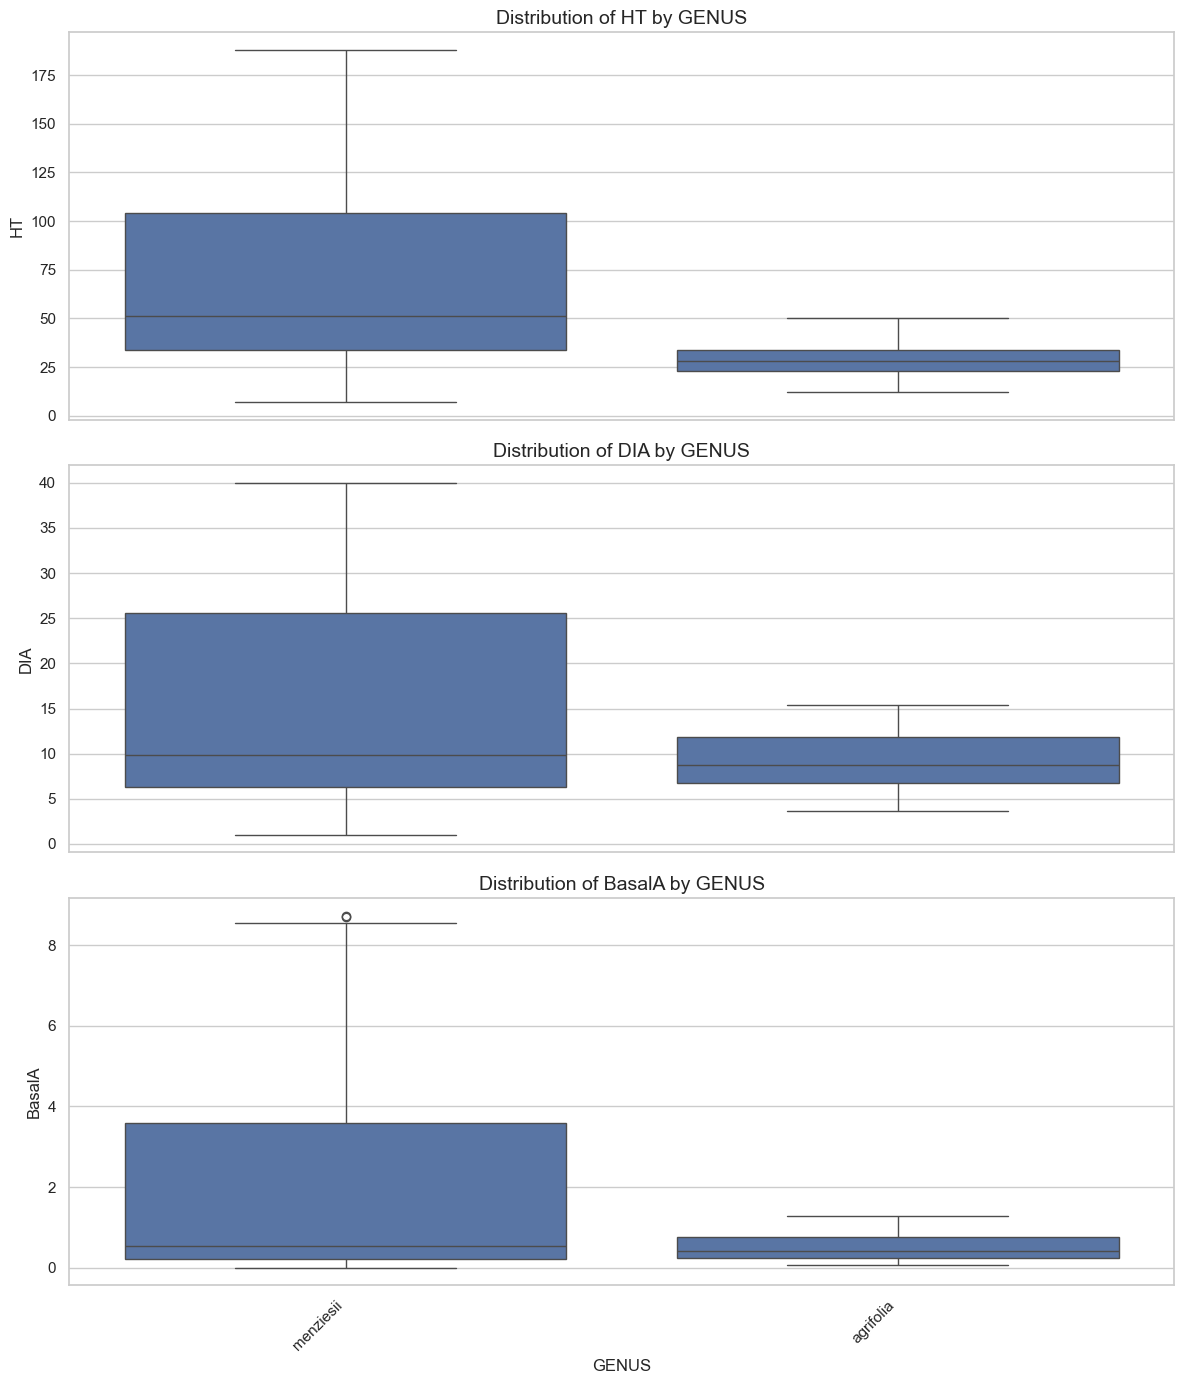

In [903]:

import seaborn as sns

import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for HT, DIA_cm, and BasalA
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# Plot for HT
sns.boxplot(data=df_encoded_filtered, x='SPECIES', y='HT', ax=axes[0])
axes[0].set_title('Distribution of HT by GENUS', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('HT')

# Plot for DIA_cm
sns.boxplot(data=df_encoded_filtered, x='SPECIES', y='DIA', ax=axes[1])
axes[1].set_title('Distribution of DIA by GENUS', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('DIA')

# Plot for BasalA
sns.boxplot(data=df_encoded_filtered, x='SPECIES', y='BasalA', ax=axes[2])
axes[2].set_title('Distribution of BasalA by GENUS', fontsize=14)
axes[2].set_xlabel('GENUS')
axes[2].set_ylabel('BasalA')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

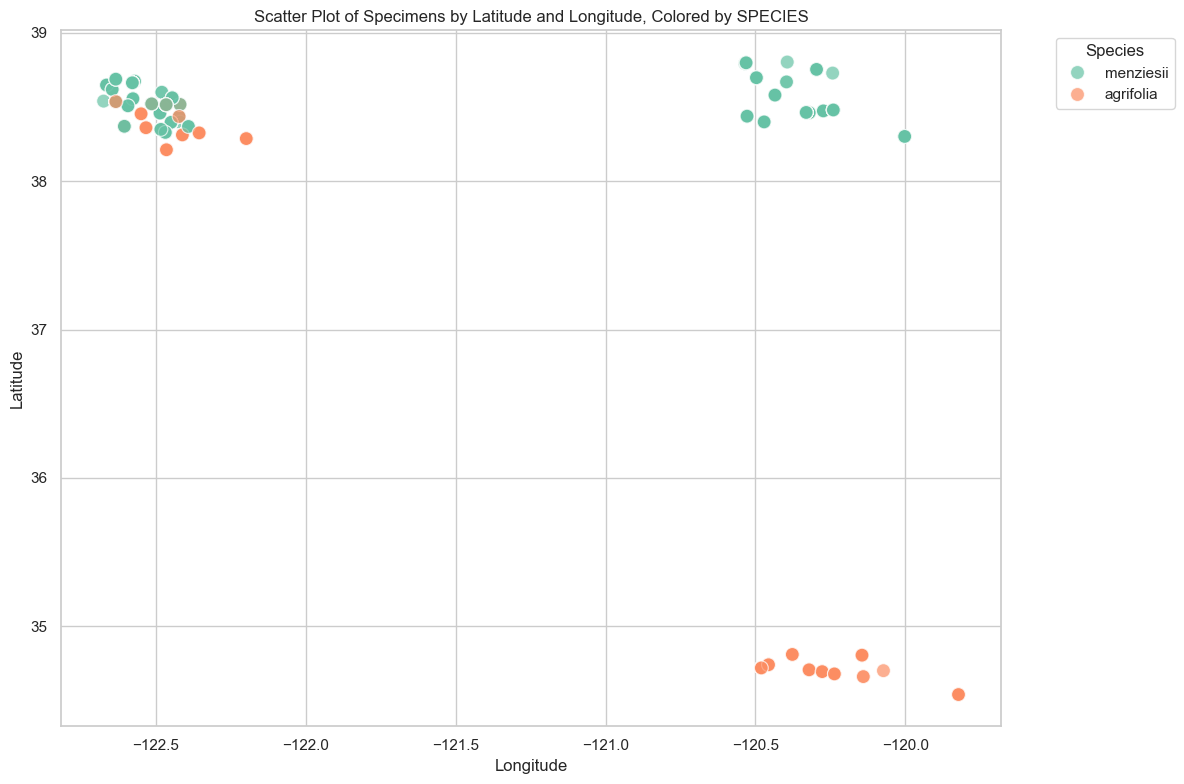

In [904]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create the scatter plot using seaborn for better styling
sns.scatterplot(
    data=df_encoded_filtered,
    x='LON',  # Longitude on X-axis
    y='LAT',  # Latitude on Y-axis
    hue='SPECIES',  # Color by GENUS
    palette='Set2',  # Optional: choose a nice color palette
    alpha=0.7,
    edgecolor='w',
    s=100  # Size of points
)

# Set labels and title
plt.title('Scatter Plot of Specimens by Latitude and Longitude, Colored by SPECIES')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [905]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
import time

# --- Prepare dataset -----------------------------------------------------------
include_vars = ['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT', 'SPECIES', 'GENUS']
df = df_encoded_species[include_vars].dropna().copy()

from sklearn.preprocessing import OneHotEncoder

# Create the encoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the PFT column (needs to be reshaped for 2D input)
pft_encoded = ohe.fit_transform(df[["PFT"]])

# Convert to DataFrame with appropriate column names
pft_encoded_df = pd.DataFrame(
    pft_encoded,
    columns=[f"PFT_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)

# Drop the original PFT column and join the encoded columns
df = df.drop(columns=["PFT"])
df = pd.concat([df, pft_encoded_df], axis=1)

#one-hot encode the GENUS column
genus_encoded = ohe.fit_transform(df[["GENUS"]])
genus_encoded_df = pd.DataFrame(
    genus_encoded,
    columns=[f"GENUS_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)
# Drop the original GENUS column and join the encoded columns
df = df.drop(columns=["GENUS"])
df = pd.concat([df, genus_encoded_df], axis=1)


X = df.drop(columns=["SPECIES"])
y = df["SPECIES"]

# Encode target variable
le_species = LabelEncoder()
y_encoded = le_species.fit_transform(y)
num_classes = len(le_species.classes_)


# Stratified train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded
)

from sklearn.compose import ColumnTransformer

# Identify numerical and categorical columns again
numerical_cols = ['DIA', 'HT', 'LAT', 'LON']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        # ("cat", OneHotEncoder(sparse_output=False), categorical_cols)
    ]
)

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# Concatenate scaled numerical and raw categorical columns
X_train_processed = np.hstack((X_train_scaled, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled, X_test[categorical_cols].values))



In [906]:
X

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,GENUS_Abies,GENUS_Acer,GENUS_Arbutus,GENUS_Calocedrus,GENUS_Pinus,GENUS_Populus,GENUS_Pseudotsuga,GENUS_Quercus,GENUS_Sequoiadendron
0,6.1,25.0,37.514660,-119.737508,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,7.0,38.153364,-120.059054,False,False,False,True,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.8,40.0,37.370380,-119.540933,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,5.0,23.0,38.798608,-120.531280,False,False,False,True,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10.6,39.0,37.972191,-119.841096,False,False,False,True,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,36.791094,-118.966081,False,False,False,False,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23719,17.6,57.0,38.001863,-120.030085,False,False,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23720,7.2,28.0,36.211111,-118.657481,False,False,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23721,2.0,10.0,37.096947,-119.360283,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [907]:
print(df_encoded_species["SPECIES"].value_counts())
print("Len :",len(df_encoded_species["SPECIES"].unique()))

SPECIES
concolor        4430
decurrens       2866
ponderosa       2733
chrysolepis     1691
kelloggii        970
lambertiana      960
jeffreyi         634
menziesii        624
agrifolia        315
douglasii        115
macrophyllum      66
giganteum         30
tremuloides       20
lobata             9
Name: count, dtype: int64
Len : 14


In [908]:
print(X_train_processed.shape)
print(X_test_processed.shape)

(10824, 20)
(4639, 20)


In [909]:
from sklearn.utils.class_weight import compute_sample_weight

# Assume X, y_encoded are your full datasets with the same number of rows
assert len(X) == len(y_encoded), "X and y_encoded must have the same number of rows."

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_encoded)

# Check all shapes
print(f"X: {X.shape}, y: {len(y_encoded)}, sample_weights: {len(sample_weights)}")

X: (15463, 20), y: 15463, sample_weights: 15463


In [910]:
X_new = np.hstack((preprocessor.fit_transform(X), X[categorical_cols].values))

In [911]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(zip(np.unique(y_train_encoded), class_weights))
# Define parameter grid for Random Forest
"""rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}"""
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
    'max_depth': [5, 10, 20, 30, 50, 70, 100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Create base model
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Randomized search
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Ensure all categorical columns are properly encoded
# Identify categorical columns in the original dataset
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# # One-hot encode categorical columns
# ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
# X_test_encoded = ohe.transform(X_test[categorical_cols])

# # Combine encoded categorical data with scaled numerical data
# X_train_processed = np.hstack((X_train_scaled, X_train_encoded))
# X_test_processed = np.hstack((X_test_scaled, X_test_encoded))

# Fit the RandomizedSearchCV
# Train the search
rf_random_search.fit(X_train_processed, y_train_encoded)

# Best model
best_rf_model = rf_random_search.best_estimator_

# Evaluate the best RF model
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

train_and_evaluate(best_rf_model, "Tuned Random Forest")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned Random Forest - Accuracy: 0.9694, Training Time: 0.75 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.94      0.85      0.89        34
           5       1.00      1.00      1.00         9
           6       0.98      0.95      0.97       190
           7       0.98      1.00      0.99       291
           8       0.87      0.68      0.76       288
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.89      0.96      0.92       820
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4639
   ma

In [912]:
#test the random forest model on the test set
predictions = best_rf_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.94      0.85      0.89        34
           5       1.00      1.00      1.00         9
           6       0.98      0.95      0.97       190
           7       0.98      1.00      0.99       291
           8       0.87      0.68      0.76       288
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.89      0.96      0.92       820
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4639
   macro avg       0.98      0.91      0.93      4639
weighted avg       0.97      0.97      0.97      4639



In [913]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid for Extra Trees
"""et_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}"""

et_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800],
    'max_depth': [5, 10, 20, 30, 50, 70, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Create ET model
et = ExtraTreesClassifier(random_state=42)

# Randomized search
et_random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=et_param_grid,
    n_iter=16,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1,  # Reduce parallel jobs to avoid memory issues
    scoring='accuracy'
)

# Fit search
et_random_search.fit(X_train_processed, y_train_encoded) 
print(et_random_search.best_params_)
best_et_model = et_random_search.best_estimator_

# Evaluate
train_and_evaluate(best_et_model, "Tuned Extra Trees")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Tuned Extra Trees - Accuracy: 0.9722, Training Time: 2.12 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.94      0.94      0.94        34
           5       1.00      1.00      1.00         9
           6       0.97      0.95      0.96       190
           7       0.99      1.00      1.00       291
           8       0.84      0.76      0.80       288
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       

In [914]:
predictions = best_et_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.94      0.94      0.94        34
           5       1.00      1.00      1.00         9
           6       0.97      0.95      0.96       190
           7       0.99      1.00      1.00       291
           8       0.84      0.76      0.80       288
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.91      0.94      0.93       820
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4639
   macro avg       0.98      0.92      0.94      4639
weighted avg       0.97      0.97      0.97      4639



In [915]:
from sklearn.tree import DecisionTreeClassifier

# Parameter grid for Decision Tree
"""dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}"""

dt_param_grid = {
    'max_depth': [5, 10, 20, 30, 50, 70, 100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random']
}


# Create DT model
dt = DecisionTreeClassifier(random_state=42)

# Randomized search
dt_random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit search
dt_random_search.fit(X_train_processed, y_train_encoded)
best_dt_model = dt_random_search.best_estimator_

# Evaluate
train_and_evaluate(best_dt_model, "Tuned Decision Tree")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned Decision Tree - Accuracy: 0.9608, Training Time: 0.02 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.91      0.85      0.88        34
           5       1.00      1.00      1.00         9
           6       0.97      0.95      0.96       190
           7       0.99      1.00      0.99       291
           8       0.72      0.75      0.73       288
           9       0.33      0.33      0.33         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.90      0.89      0.89       820
          13       1.00      1.00      1.00         6

    accuracy                           0.96      4639
   ma

In [916]:
predictions = best_dt_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.91      0.85      0.88        34
           5       1.00      1.00      1.00         9
           6       0.97      0.95      0.96       190
           7       0.99      1.00      0.99       291
           8       0.72      0.75      0.73       288
           9       0.33      0.33      0.33         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.90      0.89      0.89       820
          13       1.00      1.00      1.00         6

    accuracy                           0.96      4639
   macro avg       0.92      0.91      0.91      4639
weighted avg       0.96      0.96      0.96      4639



In [917]:
from flaml import tune
from flaml.tune import run
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""# Train/Validation split just for tuning meta-learner
X_stack_train, X_stack_val, y_stack_train, y_stack_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.2, random_state=42)
"""
# Base models remain fixed
base_models = [
    ('rf', best_rf_model),
    ('et', best_et_model),
    ('dt', best_dt_model)
]

def train_meta_learner(config):
    model = StackingClassifier(
        estimators=base_models,
        final_estimator=XGBClassifier(
            n_estimators=int(config["n_estimators"]),
            learning_rate=config["learning_rate"],
            max_depth=int(config["max_depth"]),
            min_child_weight=int(config["min_child_weight"]),
            subsample=config["subsample"],
            colsample_bytree=config["colsample_bytree"],
            gamma=config["gamma"],
            reg_alpha=config["reg_alpha"],
            reg_lambda=config["reg_lambda"],
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        cv=5,
        n_jobs=-1
    )
    model.fit(X_train_processed, y_train_encoded)
    preds = model.predict(X_test_processed)
    return {"accuracy": accuracy_score(y_test_encoded, preds)}

# Search space
search_space = {
    "n_estimators": tune.randint(50, 300),
    "learning_rate": tune.loguniform(0.01, 0.3),
    "max_depth": tune.randint(3, 8),
    "min_child_weight": tune.randint(1, 5),
    "subsample": tune.uniform(0.7, 1.0),
    "colsample_bytree": tune.uniform(0.7, 1.0),
    "gamma": tune.uniform(0, 0.3),
    "reg_alpha": tune.uniform(0, 0.1),
    "reg_lambda": tune.uniform(1, 2)
}

# Run FLAML tuner
analysis = tune.run(
    train_meta_learner,
    config=search_space,
    metric="accuracy",
    mode="max",
    num_samples=20,
    time_budget_s=600  # e.g. 10 minutes budget
)

# Get best config
best_config = analysis.get_best_config(metric="accuracy", mode="max")

# Train final stacking model with best XGB config
best_xgb_meta = XGBClassifier(
    **best_config,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_xgb_meta,
    cv=5,
    n_jobs=-1
)

final_stack_model.fit(X_train_processed, y_train_encoded)
train_and_evaluate(final_stack_model, "Stacking with AutoML-tuned XGBoost")



[flaml.tune.tune: 04-13 14:01:12] {589} INFO - Using search algorithm BlendSearch.


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
/Users/ironman/Library/Python/3.9/lib/python/site-packages/flaml/tune/searcher/suggestion.py:886: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return ot.distributions.IntUniformDistribution(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/flaml/tune/searcher/suggestion.py:871: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.Floa

[flaml.tune.tune: 04-13 14:01:12] {891} INFO - trial 1 config: {'n_estimators': 199, 'learning_rate': 0.09038377706605241, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8105978350804359, 'colsample_bytree': 0.9266460694109788, 'gamma': 0.07991772612924071, 'reg_alpha': 0.0756210682605616, 'reg_lambda': 1.01361156664789}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:01:19] {891} INFO - trial 2 config: {'n_estimators': 242, 'learning_rate': 0.010731320001845925, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8495521036907772, 'colsample_bytree': 0.7674389936592543, 'gamma': 0.05941885942788719, 'reg_alpha': 0.07605307121989588, 'reg_lambda': 1.1691108365625356}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 14:01:27] {891} INFO - trial 3 config: {'n_estimators': 72, 'learning_rate': 0.1028867751008824, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.853657679015733, 'colsample_bytree': 0.9437862884956341, 'gamma': 0.18375782004881644, 'reg_alpha': 0.07217553174317996, 'reg_lambda': 1.2918760681706332}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 14:01:33] {891} INFO - trial 4 config: {'n_estimators': 239, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8329376379567311, 'colsample_bytree': 0.7335330150834817, 'gamma': 0.09050178090592302, 'reg_alpha': 0.06360810418770582, 'reg_lambda': 1.2397565744112353}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:01:41] {891} INFO - trial 5 config: {'n_estimators': 279, 'learning_rate': 0.11363577488646587, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8120022280154408, 'colsample_bytree': 0.9022400845199036, 'gamma': 0.1325499523268988, 'reg_alpha': 0.04340139933332937, 'reg_lambda': 1.6177669784693172}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 14:01:49] {891} INFO - trial 6 config: {'n_estimators': 245, 'learning_rate': 0.018810362754422133, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8661665694248232, 'colsample_bytree': 0.8013449722350269, 'gamma': 0.028335937949851356, 'reg_alpha': 0.08849803825208594, 'reg_lambda': 1.0984650987138358}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:01:56] {891} INFO - trial 7 config: {'n_estimators': 224, 'learning_rate': 0.010870653837156043, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8792186468259113, 'colsample_bytree': 0.7256984939607427, 'gamma': 0.10105958673327625, 'reg_alpha': 0.08588188382015798, 'reg_lambda': 1.3090573821719882}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:04] {891} INFO - trial 8 config: {'n_estimators': 178, 'learning_rate': 0.09135146183055094, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8564941457180902, 'colsample_bytree': 0.9725946642426004, 'gamma': 0.09577082669656357, 'reg_alpha': 0.009045934927090738, 'reg_lambda': 1.3007000566362033}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 14:02:12] {891} INFO - trial 9 config: {'n_estimators': 78, 'learning_rate': 0.1675185096049461, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8642758467757731, 'colsample_bytree': 0.9457860987010206, 'gamma': 0.05968426190364368, 'reg_alpha': 0.08568503024577333, 'reg_lambda': 1.3516526394320878}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=299, low=50, step=1) is deprecated and internally converted to IntDistribution(high=299, log=False, low=50, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: LogUniformDistribution(high=0.3, low=0.01) is deprecated and internally converted to FloatDistribution(high=0.3, log=True, low=0.01, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:780: FutureWarning: IntUniformDistribution(high=7, low=3, step=1) is deprecated and internally converted to IntDistribution(high=7, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureW

[flaml.tune.tune: 04-13 14:02:18] {891} INFO - trial 10 config: {'n_estimators': 97, 'learning_rate': 0.16922868954182937, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8886289964012727, 'colsample_bytree': 0.9093058713501507, 'gamma': 0.04692765071497764, 'reg_alpha': 0.07252563661259252, 'reg_lambda': 1.198691968976875}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:24] {891} INFO - trial 11 config: {'n_estimators': 59, 'learning_rate': 0.16582561228972964, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8399226971502735, 'colsample_bytree': 0.9822663260518905, 'gamma': 0.07244087309230973, 'reg_alpha': 0.09884442387895413, 'reg_lambda': 1.5046133098873007}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:30] {891} INFO - trial 12 config: {'n_estimators': 127, 'learning_rate': 0.147044303029321, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8662727471547906, 'colsample_bytree': 0.9112556978741904, 'gamma': 0.026262729724812656, 'reg_alpha': 0.09055775501220953, 'reg_lambda': 1.4761772777900857}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:37] {891} INFO - trial 13 config: {'n_estimators': 50, 'learning_rate': 0.19084351098367067, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8622789463967555, 'colsample_bytree': 0.9803164995278508, 'gamma': 0.09310579408247471, 'reg_alpha': 0.08081230547933711, 'reg_lambda': 1.22712800107409}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:42] {891} INFO - trial 14 config: {'n_estimators': 50, 'learning_rate': 0.11759031284779178, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8821698987809699, 'colsample_bytree': 0.9727892959435119, 'gamma': 0.06770112105814664, 'reg_alpha': 0.07512795129562447, 'reg_lambda': 1.3365495999567587}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:48] {891} INFO - trial 15 config: {'n_estimators': 129, 'learning_rate': 0.2386459426856555, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8463817947705763, 'colsample_bytree': 0.9187829014585293, 'gamma': 0.05166740274914073, 'reg_alpha': 0.09624210919592219, 'reg_lambda': 1.366755678907417}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:02:55] {891} INFO - trial 16 config: {'n_estimators': 107, 'learning_rate': 0.17692681879672992, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8769808911612578, 'colsample_bytree': 0.9660180798954432, 'gamma': 0.11432365604274468, 'reg_alpha': 0.08061656909840781, 'reg_lambda': 1.2887888113912245}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:03:01] {891} INFO - trial 17 config: {'n_estimators': 50, 'learning_rate': 0.15861049925112367, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8515708023902884, 'colsample_bytree': 0.925554117506598, 'gamma': 0.005044867764542685, 'reg_alpha': 0.09075349139313883, 'reg_lambda': 1.4145164674729511}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:03:07] {891} INFO - trial 18 config: {'n_estimators': 50, 'learning_rate': 0.17669940545434376, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8647056790055604, 'colsample_bytree': 0.9757586487157276, 'gamma': 0.07315421489289917, 'reg_alpha': 0.09007891082446746, 'reg_lambda': 1.3440390861254639}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:03:13] {891} INFO - trial 19 config: {'n_estimators': 145, 'learning_rate': 0.1588146320476064, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8638460145459858, 'colsample_bytree': 0.9158135486863136, 'gamma': 0.04621430891438821, 'reg_alpha': 0.08129114966707918, 'reg_lambda': 1.3592661927387117}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[flaml.tune.tune: 04-13 14:03:20] {891} INFO - trial 20 config: {'n_estimators': 76, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8282969637967931, 'colsample_bytree': 0.9378929016606623, 'gamma': 0.07207776811252903, 'reg_alpha': 0.09681215169192948, 'reg_lambda': 1.3802317767584702}


/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  w

Stacking with AutoML-tuned XGBoost - Accuracy: 0.9709, Training Time: 8.23 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.94      0.97      0.96        34
           5       1.00      1.00      1.00         9
           6       0.98      0.96      0.97       190
           7       1.00      1.00      1.00       291
           8       0.85      0.70      0.77       288
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       187
          12       0.89      0.95      0.92       820
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4639
   macro avg       0.98      0.92      0.94      46

In [918]:
best_stack_xgb_model = final_stack_model

In [199]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Base models
base_models = [
    ('rf', best_rf_model),
    ('et', best_et_model),
    ('dt', best_dt_model)
]

# Stacking with XGBoost as the meta-learner
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=XGBClassifier(),  # Replacing LR with XGBClassifier
    cv=5,
    n_jobs=-1
)

# Parameter grid for XGBoost (meta-learner)
param_grid_xgb = {
    'final_estimator__n_estimators': [50, 100, 200],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'final_estimator__max_depth': [3, 4, 5, 6, 7],
    'final_estimator__min_child_weight': [1, 2, 3],
    'final_estimator__subsample': [0.7, 0.8, 0.9, 1.0],
    'final_estimator__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'final_estimator__scale_pos_weight': [1, 2, 5],  # You can adjust depending on class imbalance
    'final_estimator__gamma': [0, 0.1, 0.2],
    'final_estimator__reg_alpha': [0, 0.01, 0.1],
    'final_estimator__reg_lambda': [1, 1.5, 2]
}

# Randomized Search for XGBoost parameters
stack_search_xgb = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_grid_xgb,
    n_iter=16,  # You can increase this if needed
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=1  # Reduce parallel jobs to avoid memory issues
)

# Train
stack_search_xgb.fit(X_train_processed, y_train_encoded)

# Best model
best_stack_xgb_model = stack_search_xgb.best_estimator_

# Evaluate
train_and_evaluate(best_stack_xgb_model, "Stacking with Tuned XGBoost")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/ironman/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ironman/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The l

Stacking with Tuned XGBoost - Accuracy: 0.9691, Training Time: 6.64 seconds
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        95
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       860
           4       0.91      0.88      0.90        34
           5       1.00      1.00      1.00        10
           6       0.95      0.97      0.96       291
           7       0.99      0.99      0.99       301
           8       0.85      0.72      0.78       291
           9       0.50      0.33      0.40         3
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       238
          12       0.90      0.94      0.92       822
          13       1.00      1.00      1.00         8

    accuracy                           0.97      4817
   macro avg       0.93      0.92      0.92      4817
weig

In [919]:
Species_final = best_stack_xgb_model
# Save the model
import joblib
joblib.dump(Species_final, "Species_final_model.pkl")

['Species_final_model.pkl']

In [920]:
# load the pickle file 
import joblib
loaded_model = joblib.load("Species_final_model.pkl")
loaded_model.get_params()

{'cv': 5,
 'estimators': [('rf',
   RandomForestClassifier(class_weight={0: 3.5142857142857142,
                                        1: 0.652992277992278,
                                        2: 0.2493204956926337,
                                        3: 0.3854151830223615,
                                        4: 9.544973544973544,
                                        5: 36.816326530612244,
                                        6: 1.7413127413127414,
                                        7: 1.1386492741426468,
                                        8: 1.1505102040816326,
                                        9: 128.85714285714286,
                                        10: 16.80745341614907,
                                        11: 1.7692056227525335,
                                        12: 0.40415204241654845,
                                        13: 55.224489795918366},
                          max_depth=100, max_features='log2', n_estimators=200,
  

In [921]:
loaded_model.fit(X_new,y_encoded, sample_weight=sample_weights)

/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 3.5142857142857142,
                                                                     1: 0.652992277992278,
                                                                     2: 0.2493204956926337,
                                                                     3: 0.3854151830223615,
                                                                     4: 9.544973544973544,
                                                                     5: 36.816326530612244,
                                                                     6: 1.7413127413127414,
                                                                     7: 1.1386492741426468,
                                                                     8: 1.1505102040816326,
                                                                     9: 128.85714285714286,
                                                                     10: 16.80745341614907,
                                                                     11: 1.7692056227525335,
                                                                     12: 0.404152042416548...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.010731320001845925,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=6, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=242, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=-1)

In [922]:
predictions = loaded_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
predictions = le_species.inverse_transform(predictions)
y_test_labels = le_species.inverse_transform(y_test_encoded)  # Transform y_test_encoded to original labels
report = classification_report(y_test_labels, predictions)  # Use transformed labels
print(report)

              precision    recall  f1-score   support

   agrifolia       1.00      1.00      1.00        95
 chrysolepis       1.00      1.00      1.00       507
    concolor       1.00      1.00      1.00      1329
   decurrens       1.00      1.00      1.00       860
   douglasii       1.00      1.00      1.00        34
   giganteum       1.00      1.00      1.00         9
    jeffreyi       1.00      1.00      1.00       190
   kelloggii       1.00      1.00      1.00       291
 lambertiana       1.00      1.00      1.00       288
      lobata       1.00      1.00      1.00         3
macrophyllum       1.00      1.00      1.00        20
   menziesii       1.00      1.00      1.00       187
   ponderosa       1.00      1.00      1.00       820
 tremuloides       1.00      1.00      1.00         6

    accuracy                           1.00      4639
   macro avg       1.00      1.00      1.00      4639
weighted avg       1.00      1.00      1.00      4639



In [923]:
X.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Arbutus', 'GENUS_Calocedrus', 'GENUS_Pinus',
       'GENUS_Populus', 'GENUS_Pseudotsuga', 'GENUS_Quercus',
       'GENUS_Sequoiadendron'],
      dtype='object')

In [924]:
y.value_counts(normalize=True) * 100

SPECIES
concolor        28.649033
decurrens       18.534566
ponderosa       17.674449
chrysolepis     10.935782
kelloggii        6.273039
lambertiana      6.208368
jeffreyi         4.100110
menziesii        4.035439
agrifolia        2.037121
douglasii        0.743711
macrophyllum     0.426825
giganteum        0.194012
tremuloides      0.129341
lobata           0.058203
Name: proportion, dtype: float64

In [925]:
tree_data['SPECIES_NEW'].value_counts(normalize=True) * 100

SPECIES_NEW
decurrens       22.263624
concolor        20.912902
agrifolia       14.299022
menziesii        8.476945
contorta         8.290638
jeffreyi         5.589194
kelloggii        3.493246
densiflorus      2.980904
magnifica        2.887750
ponderosa        2.748020
douglasii        2.421984
lambertiana      1.630182
tremuloides      1.071262
chrysolepis      0.931532
sp.              0.745226
nuttalii         0.558919
lobata           0.279460
giganteum        0.232883
scouleriana      0.093153
glabrum          0.046577
macrophyllum     0.046577
Name: proportion, dtype: float64

In [926]:
TLS_species

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus


In [927]:
# One-hot encode the PFT column
genus_encoded = pd.get_dummies(TLS_species['predicted_genus'], prefix='GENUS')

# Concatenate the one-hot encoded columns with the original DataFrame
TLS_species = pd.concat([TLS_species, genus_encoded], axis=1)

# Drop the original PFT column
TLS_species.drop(columns=['predicted_genus'], inplace=True)

# Display the updated DataFrame
TLS_species.head()

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,GENUS_Abies,GENUS_Acer,GENUS_Calocedrus,GENUS_Pinus,GENUS_Pseudotsuga,GENUS_Quercus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,False,False,False,False,False,True
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,False,False,False,False,False,True
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,False,False,False,False,False,True
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,False,False,False,True,False,False
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,False,False,False,False,False,True


In [950]:
TLS_species.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Calocedrus', 'GENUS_Pinus', 'GENUS_Pseudotsuga',
       'GENUS_Quercus', 'GENUS_Arbutus', 'GENUS_Populus'],
      dtype='object')

In [951]:
# TLS_species.drop(columns=['GENUS_Lithocarpus'], inplace=True)

In [952]:
# convert the GENUS_ columns to categorical columns
# 'GENUS_Arbutus', 'GENUS_Lithocarpus', 'GENUS_Populus convert following to False in TLS_X
TLS_species['GENUS_Arbutus'] = False
TLS_species['GENUS_Lithocarpus'] = False
TLS_species['GENUS_Populus'] = False

In [953]:
TLS_species.drop(columns=['GENUS_Lithocarpus'], inplace=True)

In [954]:
len(TLS_species.columns)

19

In [955]:
len(X.columns)

20

In [956]:
len(TLS_species.columns)

19

In [957]:
TLS_species.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Calocedrus', 'GENUS_Pinus', 'GENUS_Pseudotsuga',
       'GENUS_Quercus', 'GENUS_Arbutus', 'GENUS_Populus'],
      dtype='object')

In [958]:
X.columns 

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Arbutus', 'GENUS_Calocedrus', 'GENUS_Pinus',
       'GENUS_Populus', 'GENUS_Pseudotsuga', 'GENUS_Quercus',
       'GENUS_Sequoiadendron'],
      dtype='object')

In [960]:
TLS_species["GENUS_Sequoiadendron"] = False

In [961]:
TLS_species.columns = X.columns

In [962]:
X.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Arbutus', 'GENUS_Calocedrus', 'GENUS_Pinus',
       'GENUS_Populus', 'GENUS_Pseudotsuga', 'GENUS_Quercus',
       'GENUS_Sequoiadendron'],
      dtype='object')

In [963]:
categorical_cols = [col for col in TLS_species.columns if col not in numerical_cols]

In [964]:
categorical_cols

['ECOSUBCD_261Ba',
 'ECOSUBCD_263Am',
 'ECOSUBCD_M261Ej',
 'ECOSUBCD_M261Em',
 'PFT_Deciduous broadleaf',
 'PFT_Evergreen broadleaf',
 'PFT_Evergreen conifer',
 'GENUS_Abies',
 'GENUS_Acer',
 'GENUS_Arbutus',
 'GENUS_Calocedrus',
 'GENUS_Pinus',
 'GENUS_Populus',
 'GENUS_Pseudotsuga',
 'GENUS_Quercus',
 'GENUS_Sequoiadendron']

In [965]:
TLS_species_new = np.hstack((preprocessor.fit_transform(TLS_species), TLS_species[categorical_cols].values))

In [966]:
print(TLS_species_new)

[[ 0.35278769 -0.89268611  0.39404194 ...  0.          0.
   0.        ]
 [-0.1356015  -1.29629013  0.19491186 ...  0.          0.
   0.        ]
 [ 2.76037185 -0.79659495  0.17530639 ...  0.          0.
   0.        ]
 ...
 [ 0.157475    0.96433637  1.27065322 ...  0.          0.
   0.        ]
 [-0.06725777  0.8769135  -1.51998402 ...  0.          0.
   0.        ]
 [-0.49515886 -0.98740303  1.36562501 ...  0.          0.
   0.        ]]


In [967]:
#Load the model
pred =  loaded_model.predict(TLS_species_new)

In [968]:
predicted_species = le_species.inverse_transform(pred)

In [969]:
pred

array([11, 11, 11, ...,  2,  3, 11])

In [970]:
predicted_species

array(['menziesii', 'menziesii', 'menziesii', ..., 'concolor',
       'decurrens', 'menziesii'], dtype=object)

In [971]:
pred 

array([11, 11, 11, ...,  2,  3, 11])

In [972]:
TLS_species['predicted_species'] = predicted_species.copy()

In [973]:
TLS_species 

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,...,GENUS_Abies,GENUS_Acer,GENUS_Arbutus,GENUS_Calocedrus,GENUS_Pinus,GENUS_Populus,GENUS_Pseudotsuga,GENUS_Quercus,GENUS_Sequoiadendron,predicted_species
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,menziesii
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,menziesii
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,menziesii
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,decurrens
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,menziesii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,concolor
1378,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,menziesii
1379,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,concolor
1380,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,decurrens


In [974]:
TLS_species['predicted_species'].value_counts()

predicted_species
menziesii       433
decurrens       380
concolor        264
lambertiana     114
ponderosa        66
macrophyllum     20
jeffreyi          5
lobata            4
Name: count, dtype: int64

In [975]:
df_encoded_species['SPECIES'].value_counts(normalize=True) * 100

SPECIES
concolor        28.649033
decurrens       18.534566
ponderosa       17.674449
chrysolepis     10.935782
kelloggii        6.273039
lambertiana      6.208368
jeffreyi         4.100110
menziesii        4.035439
agrifolia        2.037121
douglasii        0.743711
macrophyllum     0.426825
giganteum        0.194012
tremuloides      0.129341
lobata           0.058203
Name: proportion, dtype: float64

In [976]:
# find percentage of each predicted genus
predicted_species_counts = TLS_species['predicted_species'].value_counts(normalize=True) * 100
# Display the percentage of each predicted genus
print("Percentage of each predicted species:")
print(predicted_species_counts)

Percentage of each predicted species:
predicted_species
menziesii       33.670295
decurrens       29.548989
concolor        20.528771
lambertiana      8.864697
ponderosa        5.132193
macrophyllum     1.555210
jeffreyi         0.388802
lobata           0.311042
Name: proportion, dtype: float64


In [977]:
tree_data["SPECIES_NEW"].value_counts(normalize=True) * 100

SPECIES_NEW
decurrens       22.263624
concolor        20.912902
agrifolia       14.299022
menziesii        8.476945
contorta         8.290638
jeffreyi         5.589194
kelloggii        3.493246
densiflorus      2.980904
magnifica        2.887750
ponderosa        2.748020
douglasii        2.421984
lambertiana      1.630182
tremuloides      1.071262
chrysolepis      0.931532
sp.              0.745226
nuttalii         0.558919
lobata           0.279460
giganteum        0.232883
scouleriana      0.093153
glabrum          0.046577
macrophyllum     0.046577
Name: proportion, dtype: float64

In [ ]:
"""# save model as pickle
import pickle
with open('species_model.pkl', 'wb') as file:
    pickle.dump(loaded_model, file)
"""